# Compute rotary spectra on mitgcm outputs (SSU and SSV)



---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(35)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

<Client: scheduler='tcp://10.148.0.216:35313' processes=70 cores=280>

---


# Data files and store spectra for all faces
### important faces: 1, 2, 4, 5, 7, 8, 10, 11
### other faces: 0, 3, 6, 9, 12

In [5]:
### Here we need to load both SSU and SSV to generate the complex format of horizontal velocoty for rotary spectral calculations, u+iv

v_u = 'SSU'
v_v = 'SSV'

## open files, nc files (SSU,SSV) ##
ncdata_dir = '/home1/scratch/xyu/mit_nc_new/'

## dir where spectra will be stored
E_dir = '/home1/scratch/xyu/mit_spec/zavg_UV/'

## dir where spectra are stored for longer time than data_scratch
S_dir = '/home1/datawork/xyu/mit_zavg_spec/zavg_UV/'

print(ncdata_dir)
print(E_dir)
print(S_dir)

# number of fies to load for each face (1 file = 60 days, now )
Nf = 2

# grid file
mgrid = xr.open_dataset('/home1/scratch/xyu/mit_grid_t.nc')
mgrid = mgrid.drop(['XG','YG','i_g','j_g','k','k_u','k_l','k_p1'])


/home1/scratch/xyu/mit_nc_new/
/home1/scratch/xyu/mit_spec/zavg_UV/
/home1/datawork/xyu/mit_zavg_spec/zavg_UV/


_______
# FFT with blocks

In [6]:
#face_60 = [1, 2, 4, 5, 7, 8, 10, 11] # some key faces
face_60 = [1, 2, 4, 5] # some key faces

print(face_60)

[1, 2, 4, 5]


In [ ]:
## Here we do DFT on u+iv ##

for face in face_60:
#for face in range(0,13):
    
    # SSU #
    filenames_u = sorted(glob(ncdata_dir+v_u+'_f%02d_t*.nc' %(face)))
    filenames_u = filenames_u[:Nf]
    
    # SSV #
    filenames_v = sorted(glob(ncdata_dir+v_v+'_f%02d_t*.nc' %(face)))
    filenames_v = filenames_v[:Nf]    
    
    # Grid #
    grid = mgrid.isel(face=face)
    
    # Read SSU #
    ds = xr.open_mfdataset(filenames_u, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')
    chunks={'time': len(ds['time'])}
    ds = ds.chunk(chunks)    

    # Read SSV #
    ds_v = xr.open_mfdataset(filenames_v, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')
    chunks_v={'time': len(ds_v['time'])}
    ds_v = ds_v.chunk(chunks_v)
    
    # Merge into one xarray dataset #
    ds = xr.merge([ds_v,ds])
    
    
    nfft = 1440  # 24hours * 60 = 1440 hours
    noverlap = nfft/2
    window = np.hanning(nfft)

    SSU = ds[v_u]
    T = np.arange(0, len(SSU.time)-int(nfft/2), int(nfft/2))
    print(T)

    #u = ds[v_u] - ds[v_u].mean(dim='time')
    #v = ds[v_v] - ds[v_v].mean(dim='time')

    
    # loop for different blocks
    for t in T:
        
        uv_complex = (ds[v_u].isel(time=slice(t,t+nfft)) + 1j*ds[v_v].isel(time=slice(t,t+nfft)))    
        #uv_fft_complex = xrft.dft(window*uv_complex.fillna(0.), dim=['time'], shift=False, detrend='linear')
        uv_fft_complex = xrft.dft(uv_complex.fillna(0.), dim=['time'], shift=False, detrend='linear', window=True)        
        E_uv = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/nfft*3600
        E_uv = np.real(E_uv).rename('E_uv')
        E_uv = xr.merge([E_uv, grid])
        file_E = E_dir+'E_uv_f%02d_t%04d.nc'% (face,t)     
        E_uv.to_netcdf(file_E, mode='w')  
        print('time %d done'%t )
    
    print('face %d done'%face )

[   0  300  600  900 1200 1500 1800 2100 2400]


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:820: UserWarning: Large object of size 5.56 MB detected in task graph: 
  ("('__array_wrap__-1d944390a66b71c73876922665d175b ... ca58>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_futu

## ______

# Blocks averaging and store

In [ ]:
face_60 = [3, 6]
print(face_60)

In [ ]:
for face in range(12,13):
#for face in face_60:

    filenames = sorted(glob(E_dir+'E_uv_f%02d_t*.nc' %(face)))
    
    ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='blocks', compat='equals')    
    E_uv = (ds.E_uv).mean(dim='blocks')    
    file_E = E_dir+'E_uv_f%02d.nc'%face   
    E_uv.to_netcdf(file_E, mode='w')  
    

______
# zonally average spectra

Faces are processed independantly, this alleviate the computational burden on the scheduler (large task graph issue)


### Global ocean

In [ ]:
def fmap(v1, v2, b1, b2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        #
        i1 = np.maximum(np.rint((v1-b1['min'])/b1['d'])+1,0)
        i1 = np.minimum(i1,b1['imax'])
        #
        i2 = np.maximum(np.rint((v2-b2['min'])/b2['d'])+1,0)
        i2 = np.minimum(i2,b2['imax'])
        return i1+i2*(b1['imax']+1)

idum = 0
#for face in range(8,9):
for face in face_60:

    file_E = E_dir+'E_uv_f%02d.nc'%face    
    ds = xr.open_dataset(file_E, chunks={'i': 1, 'j': 2160})

    #
    if idum == 0:
        f = ds['freq_time']
        fv = f.values
        # lat
        vb1 = {'min': -60.,'max': 60., 'd': 1.}
        # frequency
        vb2 = {'min': fv.min(), 'max': fv.max(), 'd': fv[1]-fv[0]}
        #
        vb1['imax'] = np.int(np.rint((vb1['max']-vb1['min'])/vb1['d']))+1
        vb2['imax'] = np.int(np.rint((vb2['max']-vb2['min'])/vb2['d']))+1
        #
        lat_edges = np.arange(vb1['min'], vb1['max']+vb1['d']*.1, vb1['d'])
        lat_center = (lat_edges[:-1]+lat_edges[1:])*.5
        f_edges = np.arange(vb2['min'], vb2['max']+vb2['d']*.1, vb2['d'])
        f_center = (f_edges[:-1]+f_edges[1:])*.5
        idum +=1 

    # broadcast coordinates
    lat = ds['YC']    
    lat2 = (lat + 0.*ds.E_uv).fillna(-100.)
    f2 = lat2*0. + f
    dA = ds.rA + 0.*f2
    EdA = ds.E_uv.fillna(0.)*dA

    # apply get_index to v1 and v2 arrays
    i = dask.array.map_blocks(fmap, lat2.data, f2.data, vb1, vb2,  dtype='float')
    #print(i)

    # compute histogram of linear indices
    h, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=EdA.data)
    hnorm, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=dA.data)

    # normalize and reshape
    H = h.compute()
    Hnorm = hnorm.compute()
    H = H/Hnorm
    H = H.reshape((vb1['imax']+1,vb2['imax']+1), order='F')
    Hnorm = Hnorm.reshape((vb1['imax']+1,vb2['imax']+1), order='F')

    # put H back into an xarray
    ds_zavg = xr.Dataset({'E': (['lat', 'freq_time'],  H[1:-1,1:-1]), \
                          'A': (['lat'],  Hnorm[1:-1,1])}, \
                         coords={'lat': lat_center, 'freq_time': f_center})
    ds_zavg = ds_zavg.sortby('freq_time')

    ds_zavg.to_netcdf(E_dir+'E_rotary_zavg_f%02d.nc'%face, mode='w')

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

### open ocean (> 500 m or > 200 m)

In [ ]:

def fmap(v1, v2, b1, b2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        #
        i1 = np.maximum(np.rint((v1-b1['min'])/b1['d'])+1,0)
        i1 = np.minimum(i1,b1['imax'])
        #
        i2 = np.maximum(np.rint((v2-b2['min'])/b2['d'])+1,0)
        i2 = np.minimum(i2,b2['imax'])
        return i1+i2*(b1['imax']+1)

idum = 0
#for face in range(8,9):
for face in face_60:

    file_E = E_dir+'E_uv_f%02d.nc'%face    
    ds = xr.open_dataset(file_E, chunks={'i': 1, 'j': 2160})

    #
    if idum == 0:
        f = ds['freq_time']
        fv = f.values
        # lat
        vb1 = {'min': -60.,'max': 60., 'd': 1.}
        # frequency
        vb2 = {'min': fv.min(), 'max': fv.max(), 'd': fv[1]-fv[0]}
        #
        vb1['imax'] = np.int(np.rint((vb1['max']-vb1['min'])/vb1['d']))+1
        vb2['imax'] = np.int(np.rint((vb2['max']-vb2['min'])/vb2['d']))+1
        #
        lat_edges = np.arange(vb1['min'], vb1['max']+vb1['d']*.1, vb1['d'])
        lat_center = (lat_edges[:-1]+lat_edges[1:])*.5
        f_edges = np.arange(vb2['min'], vb2['max']+vb2['d']*.1, vb2['d'])
        f_center = (f_edges[:-1]+f_edges[1:])*.5
        idum +=1 

    # broadcast coordinates
    lat = ds['YC']    
    lat2 = (lat + 0.*ds.E_uv.where(ds.Depth>500)).fillna(-100.)
    f2 = lat2*0. + f
    dA = ds.rA + 0.*f2
    EdA = ds.E_uv.where(ds.Depth>500).fillna(0.)*dA

    # apply get_index to v1 and v2 arrays
    i = dask.array.map_blocks(fmap, lat2.data, f2.data, vb1, vb2,  dtype='float')
    #print(i)

    # compute histogram of linear indices
    h, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=EdA.data)
    hnorm, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=dA.data)

    # normalize and reshape
    H = h.compute()
    Hnorm = hnorm.compute()
    H = H/Hnorm
    H = H.reshape((vb1['imax']+1,vb2['imax']+1), order='F')
    Hnorm = Hnorm.reshape((vb1['imax']+1,vb2['imax']+1), order='F')

    # put H back into an xarray
    ds_zavg = xr.Dataset({'E': (['lat', 'freq_time'],  H[1:-1,1:-1]), \
                          'A': (['lat'],  Hnorm[1:-1,1])}, \
                         coords={'lat': lat_center, 'freq_time': f_center})
    ds_zavg = ds_zavg.sortby('freq_time')

    ds_zavg.to_netcdf(E_dir+'E_rotary_zavg_openocean_f%02d.nc'%face, mode='w')


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

### coastal ocean (< 200 or 500 m)

In [ ]:

def fmap(v1, v2, b1, b2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        #
        i1 = np.maximum(np.rint((v1-b1['min'])/b1['d'])+1,0)
        i1 = np.minimum(i1,b1['imax'])
        #
        i2 = np.maximum(np.rint((v2-b2['min'])/b2['d'])+1,0)
        i2 = np.minimum(i2,b2['imax'])
        return i1+i2*(b1['imax']+1)

idum = 0
for face in range(12,13):
#for face in face_60:

    file_E = E_dir+'E_uv_f%02d.nc'%face    
    ds = xr.open_dataset(file_E, chunks={'i': 1, 'j': 2160})

    #
    if idum == 0:
        f = ds['freq_time']
        fv = f.values
        # lat
        vb1 = {'min': -60.,'max': 60., 'd': 1.}
        # frequency
        vb2 = {'min': fv.min(), 'max': fv.max(), 'd': fv[1]-fv[0]}
        #
        vb1['imax'] = np.int(np.rint((vb1['max']-vb1['min'])/vb1['d']))+1
        vb2['imax'] = np.int(np.rint((vb2['max']-vb2['min'])/vb2['d']))+1
        #
        lat_edges = np.arange(vb1['min'], vb1['max']+vb1['d']*.1, vb1['d'])
        lat_center = (lat_edges[:-1]+lat_edges[1:])*.5
        f_edges = np.arange(vb2['min'], vb2['max']+vb2['d']*.1, vb2['d'])
        f_center = (f_edges[:-1]+f_edges[1:])*.5
        idum +=1 

    # broadcast coordinates
    lat = ds['YC']    
    lat2 = (lat + 0.*ds.E_uv.where(ds.Depth<500)).fillna(-100.)
    f2 = lat2*0. + f
    dA = ds.rA + 0.*f2
    EdA = ds.E_uv.where(ds.Depth<500).fillna(0.)*dA

    # apply get_index to v1 and v2 arrays
    i = dask.array.map_blocks(fmap, lat2.data, f2.data, vb1, vb2,  dtype='float')
    #print(i)

    # compute histogram of linear indices
    h, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=EdA.data)
    hnorm, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=dA.data)

    # normalize and reshape
    H = h.compute()
    Hnorm = hnorm.compute()
    H = H/Hnorm
    H = H.reshape((vb1['imax']+1,vb2['imax']+1), order='F')
    Hnorm = Hnorm.reshape((vb1['imax']+1,vb2['imax']+1), order='F')

    # put H back into an xarray
    ds_zavg = xr.Dataset({'E': (['lat', 'freq_time'],  H[1:-1,1:-1]), \
                          'A': (['lat'],  Hnorm[1:-1,1])}, \
                         coords={'lat': lat_center, 'freq_time': f_center})
    ds_zavg = ds_zavg.sortby('freq_time')

    ds_zavg.to_netcdf(E_dir+'E_rotary_zavg_coastalocean_f%02d.nc'%face, mode='w')


_______

# 1. load and plot zonally averaged spectra


In [160]:
#filenames = sorted(glob(S_dir+'E_rotary_zavg_f*.nc'))
#filenames = sorted(glob(S_dir+'E_rotary_zavg_openocean_500m_f*.nc'))
#filenames = sorted(glob(S_dir+'E_rotary_zavg_coastalocean_500m_f*.nc'))
#filenames = sorted(glob(S_dir+'E_rotary_zavg_openocean_200m_f*.nc'))
filenames = sorted(glob(S_dir+'E_rotary_zavg_coastalocean_200m_f*.nc'))

%time ds = xr.open_mfdataset(filenames, concat_dim='face', compat='equals')
print(ds)

CPU times: user 100 ms, sys: 12 ms, total: 112 ms
Wall time: 383 ms
<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1439, lat: 120)
Coordinates:
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
Dimensions without coordinates: face
Data variables:
    E          (face, lat, freq_time) float64 dask.array<shape=(13, 120, 1439), chunksize=(1, 120, 1439)>
    A          (face, lat) float64 dask.array<shape=(13, 120), chunksize=(1, 120)>


In [161]:
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(120, 1439)>
Coordinates:
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


### Note: (i) full colorscale [-1, 4] (ii) Shane's colorscale [0.5, 4] (iii) full frequency range [-12 12] cpd

### 1.1 Global ocean

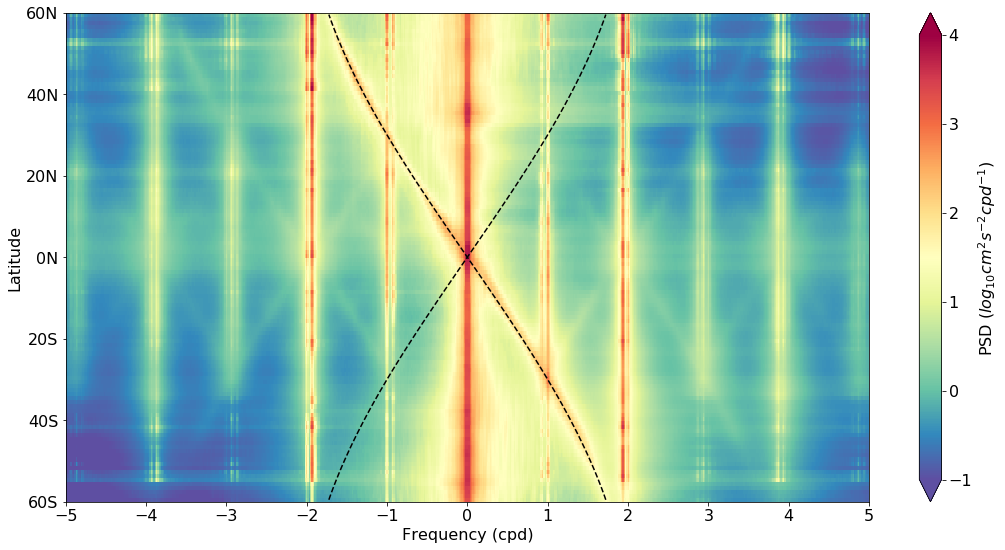

In [54]:
plt.figure(figsize=(18,9))
ax = plt.subplot(1,1,1)

E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
cax = np.log10(E/8.64).plot.pcolormesh(ax=ax, vmin=-1., vmax=4., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=16)
            
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)

# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'k--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_uv_face0-12_full.png')

### 1.2 open-ocean

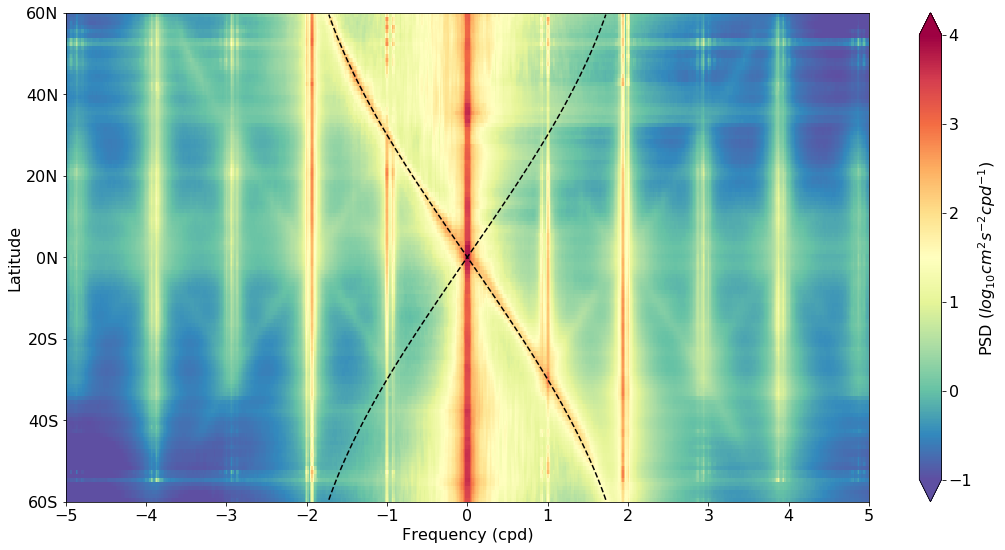

In [150]:
# Figure #

plt.figure(figsize=(18,9))
ax = plt.subplot(1,1,1)

E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
cax = np.log10(E/8.64).plot.pcolormesh(ax=ax, vmin=-1., vmax=4., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=16)
            
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)

# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'k--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_uv_face0-12_openocean.png')



### 1.3 coastal ocean

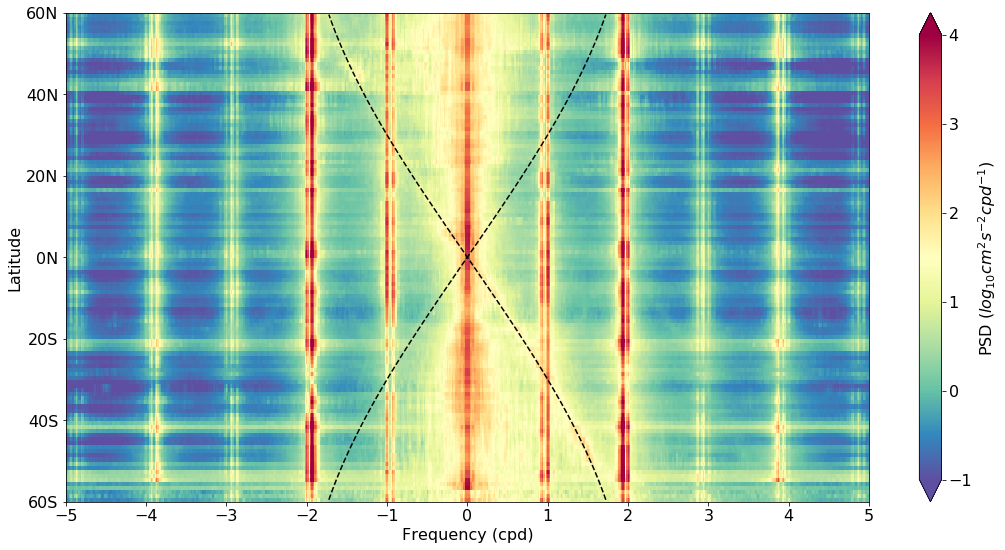

In [162]:

plt.figure(figsize=(18,9))
ax = plt.subplot(1,1,1)

E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
cax = np.log10(E/8.64).plot.pcolormesh(ax=ax, vmin=-1., vmax=4., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=16)
            
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)


# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'k--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_uv_face0-12_coastalocean.png')


# 2. Band-frequency integral

In [163]:
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(120, 1439)>
Coordinates:
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


In [164]:
df=E.freq_time[1]-E.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(1.929012e-07)


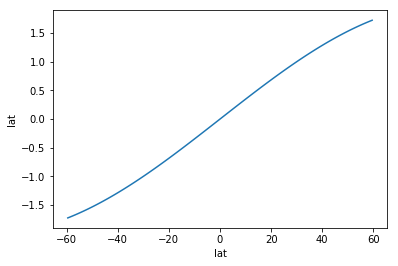

In [165]:
# Inertial frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
f_cpd = f*86400/2./np.pi
f_cpd.plot()

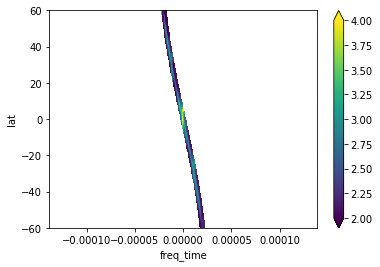

In [31]:
np.log10(E.where(abs(E.freq_cpd+f_cpd)<.2, other=0.)).plot(vmin=2, vmax=4)

## Total energy vs Band-frequency integral

In [31]:
np.arcsin(0.25)*180/np.pi

14.477512185929923

### 2.1 Global ocean

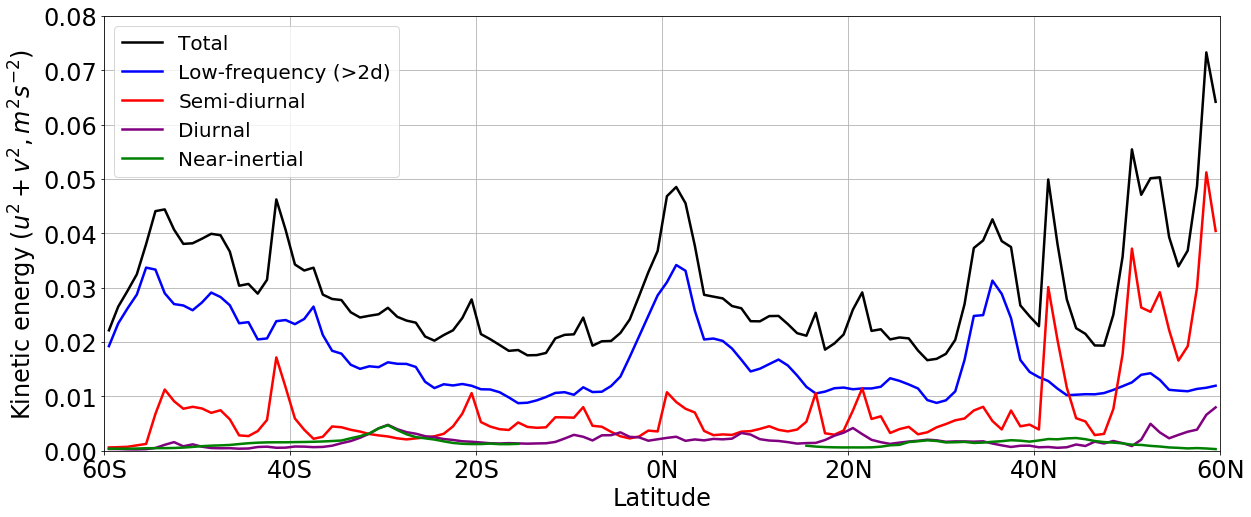

In [147]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (>2d)','Semi-diurnal', 'Diurnal', 'Near-inertial']


(E*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E.where((abs(E.freq_cpd)>0) & (abs(E.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[1], linewidth=2.5)   # energy at low frequencies (> 5 days) 
(E.where((abs(E.freq_cpd)>1.9) & (abs(E.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
(E.where((abs(E.freq_cpd)>0.9) & (abs(E.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='purple', label=labels[3], linewidth=2.5) # energy around diurnal frequencies
(E.where(abs(E.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E.lat)>15).plot(color='green', label=labels[4], linewidth=2.5) # energy around f
ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.08])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Freq-integral KE_allocean.png')

### 2.2 Open-ocean

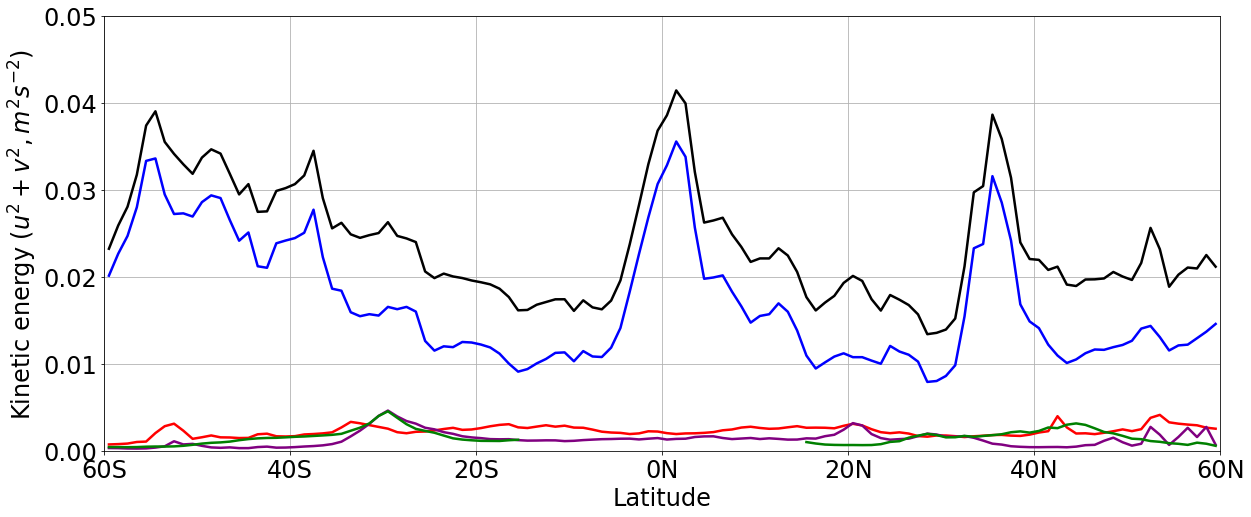

In [159]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (>2d)','Semi-diurnal', 'Diurnal', 'Near-inertial']

(E*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E.where((abs(E.freq_cpd)>0) & (abs(E.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[1], linewidth=2.5)   # energy at low frequencies (> 5 days) 
(E.where((abs(E.freq_cpd)>1.9) & (abs(E.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
(E.where((abs(E.freq_cpd)>0.9) & (abs(E.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='purple', label=labels[3], linewidth=2.5) # energy around diurnal frequencies
(E.where(abs(E.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E.lat)>15).plot(color='green', label=labels[4], linewidth=2.5) # energy around f

#ax.legend(prop={'size': 20}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.05])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Freq-integral KE_openocean.png')

### 2.3 Coastal ocean

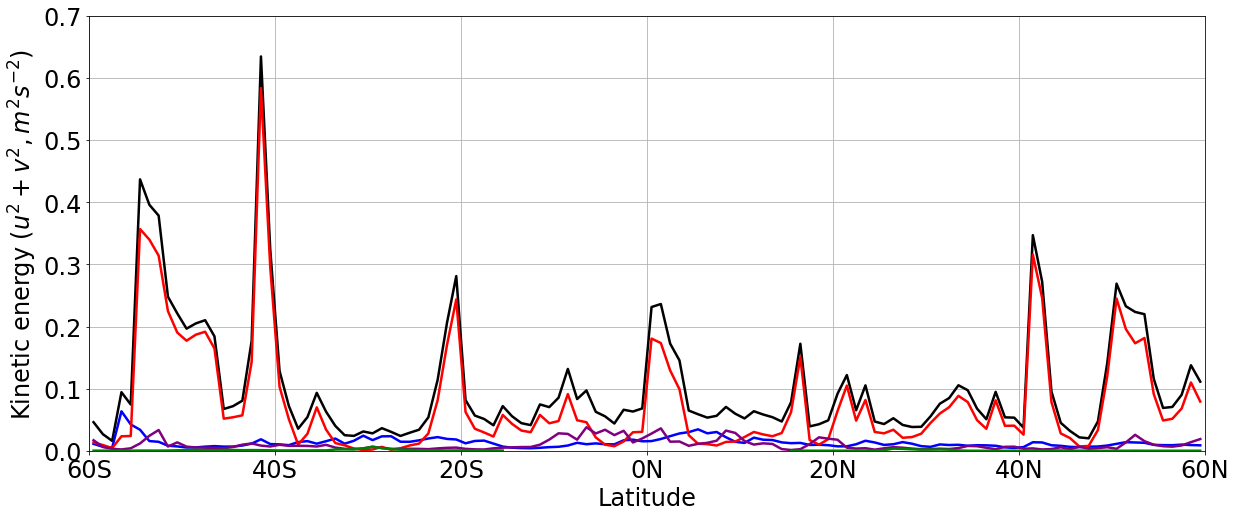

In [167]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (>2d)','Semi-diurnal', 'Diurnal', 'Near-inertial']

(E*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E.where((abs(E.freq_cpd)>0) & (abs(E.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[1], linewidth=2.5)   # energy at low frequencies (> 5 days) 
(E.where((abs(E.freq_cpd)>1.9) & (abs(E.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
(E.where((abs(E.freq_cpd)>0.9) & (abs(E.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='purple', label=labels[3], linewidth=2.5) # energy around diurnal frequencies
(E.where(abs(E.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E.lat)>15).plot(color='green', label=labels[4], linewidth=2.5) # energy around f

#ax.legend(prop={'size': 20}); 
ax.grid()


# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.7])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Freq-integral KE_coastalocean.png')

# 3. face-averaged spectra

## 3.1 Compute globally-averaged spectra

In [172]:
filenames_u = sorted(glob(E_dir+'E_uv_f*.nc'))

# Read SSU #
ds = xr.open_mfdataset(filenames_u, chunks={'i':10, 'j':432}, concat_dim='face', compat='equals')
chunks={'face': len(ds['face'])}
ds = ds.chunk(chunks)
print(ds)

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:            (face: 9, freq_time: 1440, i: 4320, j: 4320)
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 1.929e-07
  * face               (face) int64 0 1 2 4 5 7 8 10 11
    XC                 (face, i, j) float32 dask.array<shape=(9, 4320, 4320), chunksize=(9, 10, 432)>
    YC                 (face, i, j) float32 dask.array<shape=(9, 4320, 4320), chunksize=(9, 10, 432)>
    rA                 (face, i, j) float32 dask.array<shape=(9, 4320, 4320), chunksize=(9, 10, 432)>
    Depth              (face, i, j) float32 dask.array<shape=(9, 4320, 4320), chunksize=(9, 10, 432)>
Data variables:
    E_uv               (face, i, j, freq_time) float64 dask.array<shape=(9, 4320, 4320, 1440), chunksize=(9, 10, 432, 1440)>


(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-57.50102615, -57.40102615, -57.30102615, -57.20102615,
        -57.10102615, -57.00102615, -56.90102615, -56.80102615,
        -56.70102615, -56.60102615, -56.50102615]),
 <a list of 10 Patch objects>)

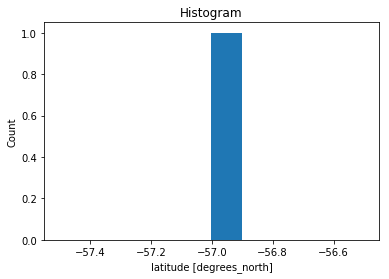

In [22]:
ds.YC.isel(face=1,i=10,j=0).plot()

### 3.1.1 All the world oceans

In [12]:
E_uv = (ds.E_uv).where(ds.YC>0.).mean(dim=('i','j','face'))   
file_E = E_dir+'E_uv_north_mean.nc'  
%time E_uv.to_netcdf(file_E, mode='w')  

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


CPU times: user 47min 10s, sys: 1min 22s, total: 48min 32s
Wall time: 1h 8min 43s


In [13]:
E_uv = (ds.E_uv).where(ds.YC<0.).mean(dim=('i','j','face'))   
file_E = E_dir+'E_uv_south_mean.nc'  
%time E_uv.to_netcdf(file_E, mode='w')  

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


CPU times: user 49min 52s, sys: 1min 30s, total: 51min 23s
Wall time: 1h 9min 47s


### 3.1.2 Open ocean

In [ ]:
E_uv = ((ds.E_uv).where((ds.YC>0.) & (ds.Depth>200.))).mean(dim=('i','j','face'))   
file_E = E_dir+'E_uv_north_allmean_openocean.nc'  
%time E_uv.to_netcdf(file_E, mode='w')  

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [7]:
E_uv = ((ds.E_uv).where((ds.YC<0.) & (ds.Depth>200.))).mean(dim=('i','j','face'))   
file_E = E_dir+'E_uv_south_allmean_openocean.nc'  
%time E_uv.to_netcdf(file_E, mode='w')  

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 42min 36s, sys: 1min 47s, total: 44min 23s
Wall time: 2h 26min 6s


### 3.1.3 Coastal ocean

In [ ]:
E_uv = ((ds.E_uv).where((ds.YC>0.) & (ds.Depth<200.))).mean(dim=('i','j','face'))   
file_E = E_dir+'E_uv_north_allmean_coastalocean.nc'  
%time E_uv.to_netcdf(file_E, mode='w')  

In [ ]:
E_uv = ((ds.E_uv).where((ds.YC<0.) & (ds.Depth<200.))).mean(dim=('i','j','face'))   
file_E = E_dir+'E_uv_south_allmean_coastalocean.nc'  
%time E_uv.to_netcdf(file_E, mode='w')  

## 3.2 Read results and plot figures_all oceans

In [6]:
face =1 

filenames_u = sorted(glob(E_dir+'E_uv_south_mean.nc'))

# Grid #
grid = mgrid.isel(face=face)
# Read SSU #
ds = xr.open_mfdataset(filenames_u)
print(ds)

<xarray.Dataset>
Dimensions:                        (freq_time: 1440)
Coordinates:
  * freq_time                      (freq_time) float64 0.0 1.929e-07 ...
    freq_time_spacing              float64 ...
Data variables:
    __xarray_dataarray_variable__  (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>


In [7]:
E_south = ds.__xarray_dataarray_variable__
E_south = E_south.assign_coords(freq_time=ds.__xarray_dataarray_variable__.freq_time * 86400.) 
print(E_south)

<xarray.DataArray '__xarray_dataarray_variable__' (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...


In [8]:
E0_south = E_south/8.64

In [9]:
#filenames_u = sorted(glob(E_dir+'E_uv_allface_mean.nc'))
filenames_u = sorted(glob(E_dir+'E_uv_north_mean.nc'))

# Grid #
grid = mgrid.isel(face=face)
# Read SSU #
ds0 = xr.open_mfdataset(filenames_u)
print(ds0)

<xarray.Dataset>
Dimensions:                        (freq_time: 1440)
Coordinates:
  * freq_time                      (freq_time) float64 0.0 1.929e-07 ...
    freq_time_spacing              float64 ...
Data variables:
    __xarray_dataarray_variable__  (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>


In [10]:
E_north = ds0.__xarray_dataarray_variable__
E_north = E_north.assign_coords(freq_time=ds0.__xarray_dataarray_variable__.freq_time * 86400.) 
print(E_north)

<xarray.DataArray '__xarray_dataarray_variable__' (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...


In [11]:
E0_north = E_north/8.64

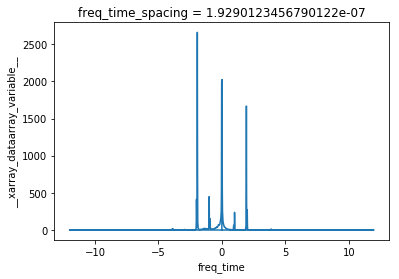

In [12]:
E0_north.plot()

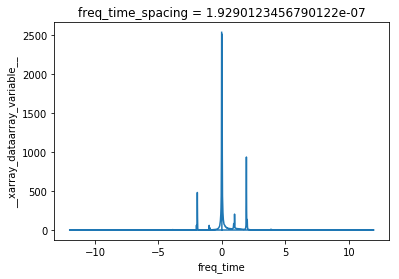

In [13]:
E0_south.plot()

In [14]:
E0_south_anti = E0_south.where(E0_south.freq_time>0)
print(E0_south_anti)

E0_north_anti = E0_north.where(E0_north.freq_time<0)
E0_north_anti = E0_north_anti.assign_coords(freq_time=E_north.freq_time * -1.) 
print(E0_north_anti)

<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07
<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 -0.01667 -0.03333 -0.05 ...
    freq_time_spacing  float64 ...


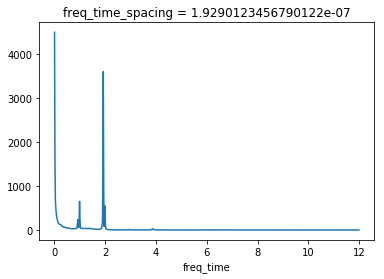

In [15]:
E0_anti = E0_north_anti + E0_south_anti
E0_anti.plot()

In [16]:
E0_south_cycl = E0_south.where(E0_south.freq_time<0)
print(E0_south_cycl)

E0_north_cycl = E0_north.where(E0_north.freq_time>0)
E0_north_cycl = E0_north_cycl.assign_coords(freq_time=E_north.freq_time * -1.) 
print(E0_north_cycl)

<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07
<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 -0.01667 -0.03333 -0.05 ...
    freq_time_spacing  float64 ...


In [17]:
E0_cycl = E0_north_cycl + E0_south_cycl
E0_cycl = E0_cycl.assign_coords(freq_time=E0_cycl.freq_time * -1.) 

print(E0_cycl)

<xarray.DataArray (freq_time: 1439)>
dask.array<shape=(1439,), dtype=float64, chunksize=(1439,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07


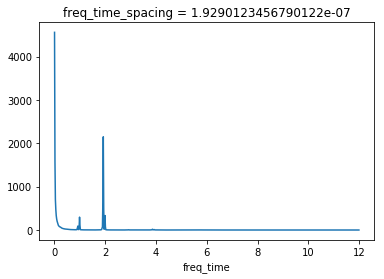

In [18]:
E0_cycl.plot()

In [19]:
E_cycl_all = E0_cycl
E_anti_all = E0_anti

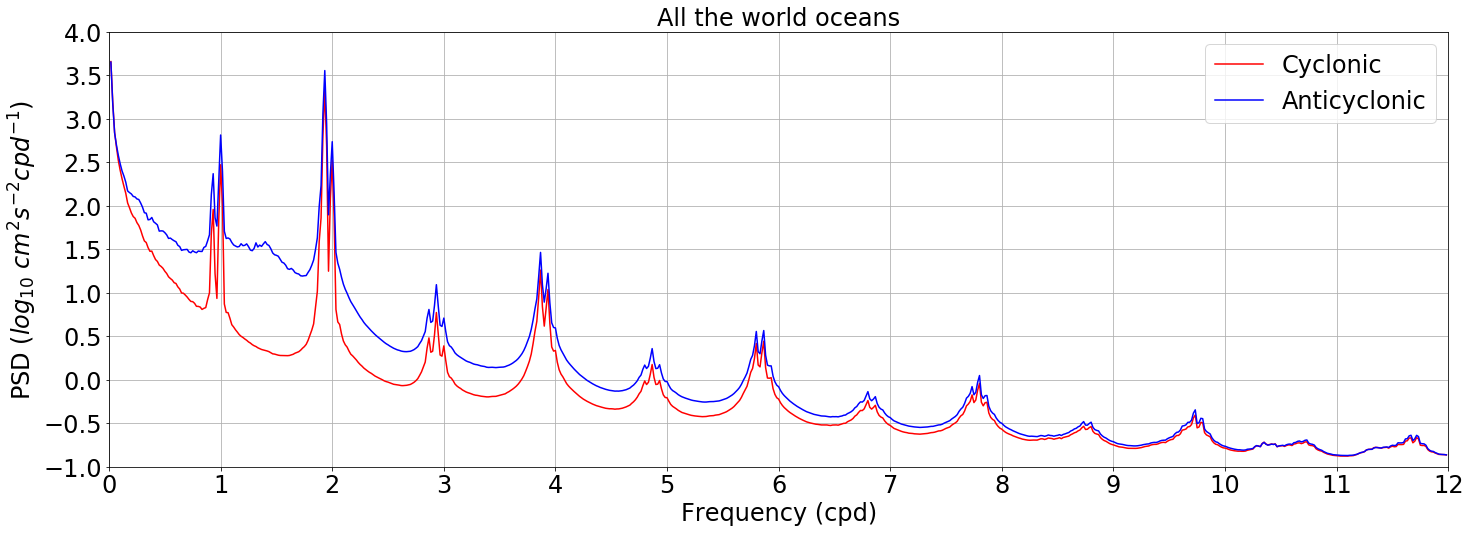

In [20]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(np.log10(E_cycl_all).where(E_cycl_all.freq_time>0)).plot(ax=ax,color='red', label=labels[0])
(np.log10(E_anti_all).where(E_anti_all.freq_time>0)).plot(ax=ax,color='blue', label=labels[1])

ax.legend(); ax.grid()
#ax.set_yscale('log')
ax.set_ylim([-1.,4.])
ax.set_yticks([-1, -0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4.])

ax.set_xlim([0.,12.])
#ax.set_ylim([1e-1,1e4])


ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('All the world oceans',fontsize=24)


plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Globally_averaged_PSD_alloceans.png')



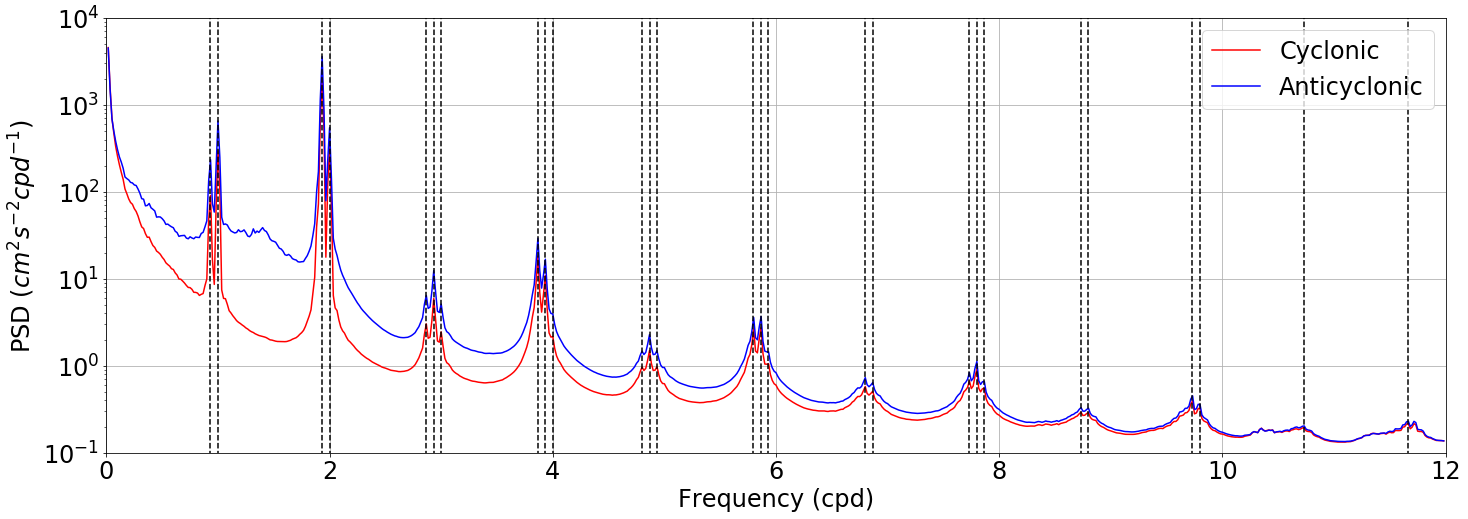

In [30]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(E0_cycl.where(E0_cycl.freq_time>0)).plot(ax=ax,color='red', label=labels[0])
(E0_anti.where(E0_anti.freq_time>0)).plot(ax=ax,color='blue', label=labels[1])

ax.legend(); ax.grid()
ax.set_yscale('log')
#ax.set_ylim([-0.5,4.5])
#ax.set_yticks([-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5])

ax.set_xlim([0.,12.])
ax.set_ylim([1e-1,1e4])


#ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('')

# Diurnal frequencies
ax.plot([24/25.81933871,24/25.81933871],[1e-2,1e6],'k--') # O1
ax.plot([1,1],[1e-2,1e6],'k--') # S1

# Semi-diurnal frequencies
ax.plot([1.93227,1.93227],[1e-2,1e6],'k--') # M2
ax.plot([2,2],[1e-2,1e6],'k--') # S2

# 3
ax.plot([2.86181,2.86181],[1e-2,1e6],'k--') # MO3
ax.plot([2.93501,2.93501],[1e-2,1e6],'k--') # MK3
ax.plot([3.00274,3.00274],[1e-2,1e6],'k--') # SK3

# 4
ax.plot([3.86455,3.86455],[1e-2,1e6],'k--') # M4
ax.plot([3.93227,3.93227],[1e-2,1e6],'k--') # MS4
ax.plot([4,4],[1e-2,1e6],'k--') # S4

# 5
ax.plot([4.79956,4.79956],[1e-2,1e6],'k--') # 3MP5
ax.plot([4.86729,4.86729],[1e-2,1e6],'k--') # 2MK5
ax.plot([4.93501,4.93501],[1e-2,1e6],'k--') # MSK5

# 6
ax.plot([5.79682,5.79682],[1e-2,1e6],'k--') # M6
ax.plot([5.86455,5.86455],[1e-2,1e6],'k--') # 2MS6
ax.plot([5.93227,5.93227],[1e-2,1e6],'k--') # 2SM6

# 7
ax.plot([6.79956,6.79956],[1e-2,1e6],'k--') # 3MK7
ax.plot([6.86729,6.86729],[1e-2,1e6],'k--') # ST17

# 8
ax.plot([7.72909,7.72909],[1e-2,1e6],'k--') # M8
ax.plot([7.8023,7.8023],[1e-2,1e6],'k--')   # 3MK8
ax.plot([7.86455,7.86455],[1e-2,1e6],'k--') # ST23

# 9
ax.plot([8.73183,8.73183],[1e-2,1e6],'k--') # M4MK9
ax.plot([8.79956,8.79956],[1e-2,1e6],'k--') # ST27


# 10
ax.plot([9.72909,9.72909],[1e-2,1e6],'k--') # ST30
ax.plot([9.79682,9.79682],[1e-2,1e6],'k--') # ST32

# 11
ax.plot([10.7318,10.7318],[1e-2,1e6],'k--') # ST33


# 12
ax.plot([11.6614,11.6614],[1e-2,1e6],'k--') # ST34

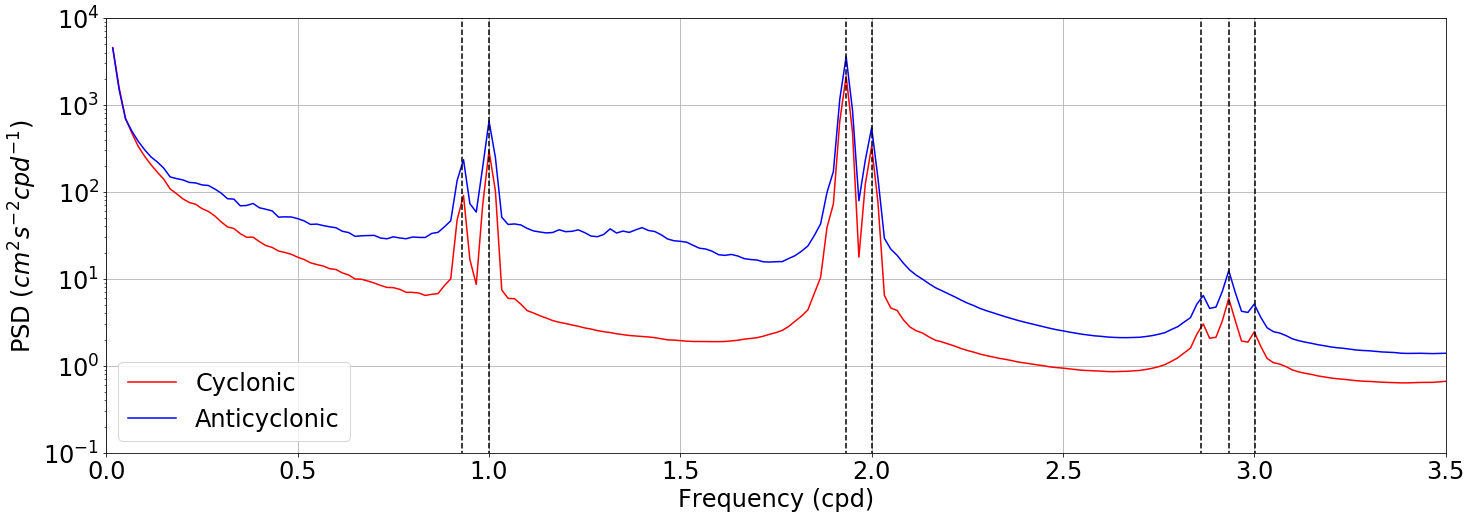

In [31]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(E0_cycl.where(E0_cycl.freq_time>0)).plot(ax=ax,color='red', label=labels[0])
(E0_anti.where(E0_anti.freq_time>0)).plot(ax=ax,color='blue', label=labels[1])

ax.legend(); ax.grid()
ax.set_yscale('log')
#ax.set_ylim([-0.5,4.5])
#ax.set_yticks([-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5])

ax.set_xlim([0.,3.5])
ax.set_ylim([1e-1,1e4])


#ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('')

# Diurnal frequencies
ax.plot([24/25.81933871,24/25.81933871],[1e-2,1e6],'k--') # O1
ax.plot([1,1],[1e-2,1e6],'k--') # S1

# Semi-diurnal frequencies
ax.plot([1.93227,1.93227],[1e-2,1e6],'k--') # M2
ax.plot([2,2],[1e-2,1e6],'k--') # S2

# 3
ax.plot([2.86181,2.86181],[1e-2,1e6],'k--') # MO3
ax.plot([2.93501,2.93501],[1e-2,1e6],'k--') # MK3
ax.plot([3.00274,3.00274],[1e-2,1e6],'k--') # SK3

# 4
ax.plot([3.86455,3.86455],[1e-2,1e6],'k--') # M4
ax.plot([3.93227,3.93227],[1e-2,1e6],'k--') # MS4
ax.plot([4,4],[1e-2,1e6],'k--') # S4

# 5
ax.plot([4.79956,4.79956],[1e-2,1e6],'k--') # 3MP5
ax.plot([4.86729,4.86729],[1e-2,1e6],'k--') # 2MK5
ax.plot([4.93501,4.93501],[1e-2,1e6],'k--') # MSK5

# 6
ax.plot([5.79682,5.79682],[1e-2,1e6],'k--') # M6
ax.plot([5.86455,5.86455],[1e-2,1e6],'k--') # 2MS6
ax.plot([5.93227,5.93227],[1e-2,1e6],'k--') # 2SM6

# 7
ax.plot([6.79956,6.79956],[1e-2,1e6],'k--') # 3MK7
ax.plot([6.86729,6.86729],[1e-2,1e6],'k--') # ST17

# 8
ax.plot([7.72909,7.72909],[1e-2,1e6],'k--') # M8
ax.plot([7.8023,7.8023],[1e-2,1e6],'k--')   # 3MK8
ax.plot([7.86455,7.86455],[1e-2,1e6],'k--') # ST23

# 9
ax.plot([8.73183,8.73183],[1e-2,1e6],'k--') # M4MK9
ax.plot([8.79956,8.79956],[1e-2,1e6],'k--') # ST27


# 10
ax.plot([9.72909,9.72909],[1e-2,1e6],'k--') # ST30
ax.plot([9.79682,9.79682],[1e-2,1e6],'k--') # ST32

# 11
ax.plot([10.7318,10.7318],[1e-2,1e6],'k--') # ST33


# 12
ax.plot([11.6614,11.6614],[1e-2,1e6],'k--') # ST34

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Globally_averaged_PSD_nowindow_1.png')



No handles with labels found to put in legend.
No handles with labels found to put in legend.


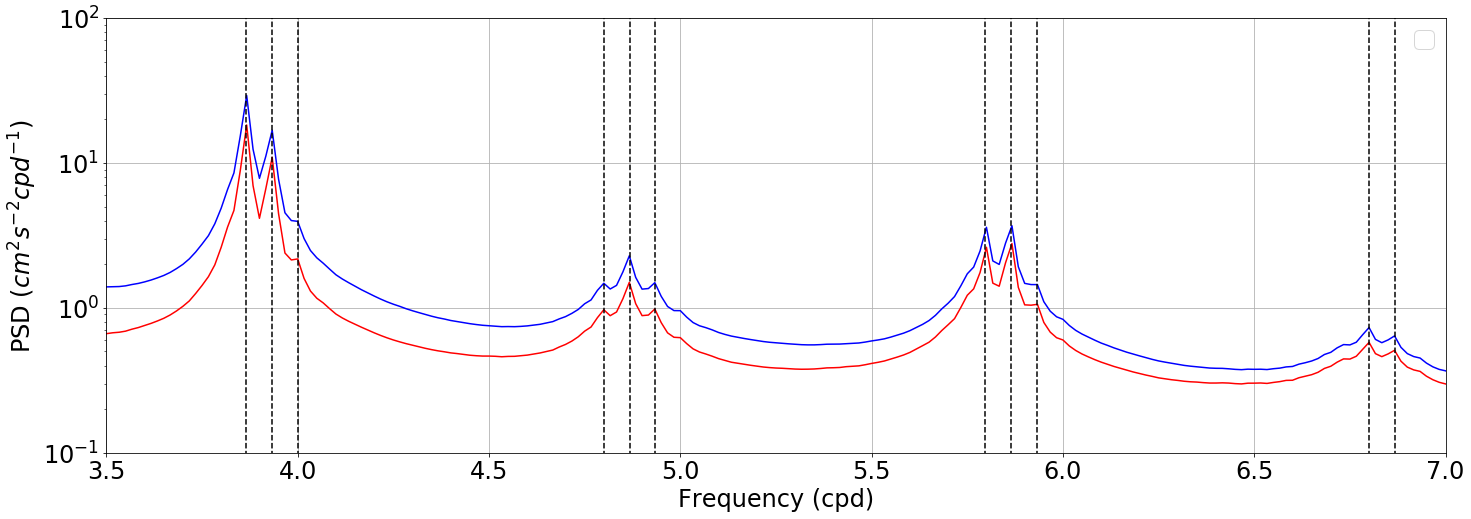

In [32]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(E0_cycl.where(E0_cycl.freq_time>0)).plot(ax=ax,color='red')
(E0_anti.where(E0_anti.freq_time>0)).plot(ax=ax,color='blue')

ax.legend(); ax.grid()
ax.set_yscale('log')
#ax.set_ylim([-0.5,4.5])
#ax.set_yticks([-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5])

ax.set_xlim([3.5,7.])
ax.set_ylim([1e-1,1e2])


#ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('')

# Diurnal frequencies
ax.plot([24/25.81933871,24/25.81933871],[1e-2,1e6],'k--') # O1
ax.plot([1,1],[1e-2,1e6],'k--') # S1

# Semi-diurnal frequencies
ax.plot([1.93227,1.93227],[1e-2,1e6],'k--') # M2
ax.plot([2,2],[1e-2,1e6],'k--') # S2

# 3
ax.plot([2.86181,2.86181],[1e-2,1e6],'k--') # MO3
ax.plot([2.93501,2.93501],[1e-2,1e6],'k--') # MK3
ax.plot([3.00274,3.00274],[1e-2,1e6],'k--') # SK3

# 4
ax.plot([3.86455,3.86455],[1e-2,1e6],'k--') # M4
ax.plot([3.93227,3.93227],[1e-2,1e6],'k--') # MS4
ax.plot([4,4],[1e-2,1e6],'k--') # S4

# 5
ax.plot([4.79956,4.79956],[1e-2,1e6],'k--') # 3MP5
ax.plot([4.86729,4.86729],[1e-2,1e6],'k--') # 2MK5
ax.plot([4.93501,4.93501],[1e-2,1e6],'k--') # MSK5

# 6
ax.plot([5.79682,5.79682],[1e-2,1e6],'k--') # M6
ax.plot([5.86455,5.86455],[1e-2,1e6],'k--') # 2MS6
ax.plot([5.93227,5.93227],[1e-2,1e6],'k--') # 2SM6

# 7
ax.plot([6.79956,6.79956],[1e-2,1e6],'k--') # 3MK7
ax.plot([6.86729,6.86729],[1e-2,1e6],'k--') # ST17

# 8
ax.plot([7.72909,7.72909],[1e-2,1e6],'k--') # M8
ax.plot([7.8023,7.8023],[1e-2,1e6],'k--')   # 3MK8
ax.plot([7.86455,7.86455],[1e-2,1e6],'k--') # ST23

# 9
ax.plot([8.73183,8.73183],[1e-2,1e6],'k--') # M4MK9
ax.plot([8.79956,8.79956],[1e-2,1e6],'k--') # ST27


# 10
ax.plot([9.72909,9.72909],[1e-2,1e6],'k--') # ST30
ax.plot([9.79682,9.79682],[1e-2,1e6],'k--') # ST32

# 11
ax.plot([10.7318,10.7318],[1e-2,1e6],'k--') # ST33


# 12
ax.plot([11.6614,11.6614],[1e-2,1e6],'k--') # ST34

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Globally_averaged_PSD_nowindow_2.png')



No handles with labels found to put in legend.
No handles with labels found to put in legend.


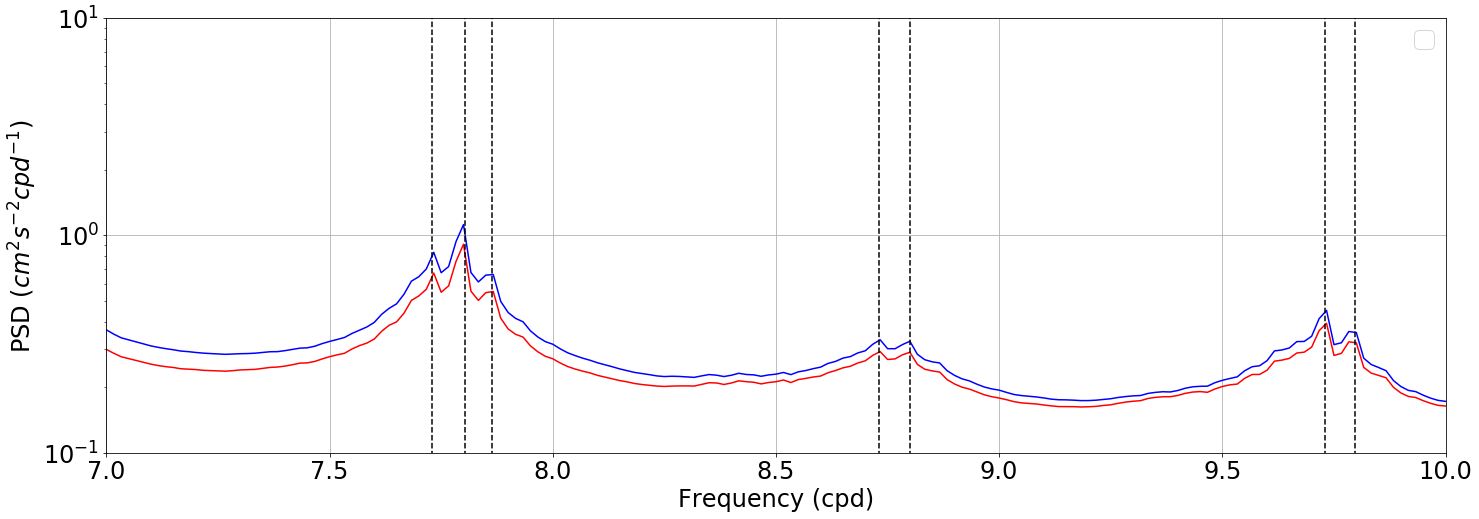

In [33]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(E0_cycl.where(E0_cycl.freq_time>0)).plot(ax=ax,color='red')
(E0_anti.where(E0_anti.freq_time>0)).plot(ax=ax,color='blue')

ax.legend(); ax.grid()
ax.set_yscale('log')
#ax.set_ylim([-0.5,4.5])
#ax.set_yticks([-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5])

ax.set_xlim([7.,10.])
ax.set_ylim([1e-1,1e1])


#ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('')

# Diurnal frequencies
ax.plot([24/25.81933871,24/25.81933871],[1e-2,1e6],'k--') # O1
ax.plot([1,1],[1e-2,1e6],'k--') # S1

# Semi-diurnal frequencies
ax.plot([1.93227,1.93227],[1e-2,1e6],'k--') # M2
ax.plot([2,2],[1e-2,1e6],'k--') # S2

# 3
ax.plot([2.86181,2.86181],[1e-2,1e6],'k--') # MO3
ax.plot([2.93501,2.93501],[1e-2,1e6],'k--') # MK3
ax.plot([3.00274,3.00274],[1e-2,1e6],'k--') # SK3

# 4
ax.plot([3.86455,3.86455],[1e-2,1e6],'k--') # M4
ax.plot([3.93227,3.93227],[1e-2,1e6],'k--') # MS4
ax.plot([4,4],[1e-2,1e6],'k--') # S4

# 5
ax.plot([4.79956,4.79956],[1e-2,1e6],'k--') # 3MP5
ax.plot([4.86729,4.86729],[1e-2,1e6],'k--') # 2MK5
ax.plot([4.93501,4.93501],[1e-2,1e6],'k--') # MSK5

# 6
ax.plot([5.79682,5.79682],[1e-2,1e6],'k--') # M6
ax.plot([5.86455,5.86455],[1e-2,1e6],'k--') # 2MS6
ax.plot([5.93227,5.93227],[1e-2,1e6],'k--') # 2SM6

# 7
ax.plot([6.79956,6.79956],[1e-2,1e6],'k--') # 3MK7
ax.plot([6.86729,6.86729],[1e-2,1e6],'k--') # ST17

# 8
ax.plot([7.72909,7.72909],[1e-2,1e6],'k--') # M8
ax.plot([7.8023,7.8023],[1e-2,1e6],'k--')   # 3MK8
ax.plot([7.86455,7.86455],[1e-2,1e6],'k--') # ST23

# 9
ax.plot([8.73183,8.73183],[1e-2,1e6],'k--') # M4MK9
ax.plot([8.79956,8.79956],[1e-2,1e6],'k--') # ST27


# 10
ax.plot([9.72909,9.72909],[1e-2,1e6],'k--') # ST30
ax.plot([9.79682,9.79682],[1e-2,1e6],'k--') # ST32

# 11
ax.plot([10.7318,10.7318],[1e-2,1e6],'k--') # ST33


# 12
ax.plot([11.6614,11.6614],[1e-2,1e6],'k--') # ST34

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Globally_averaged_PSD_nowindow_3.png')



No handles with labels found to put in legend.
No handles with labels found to put in legend.


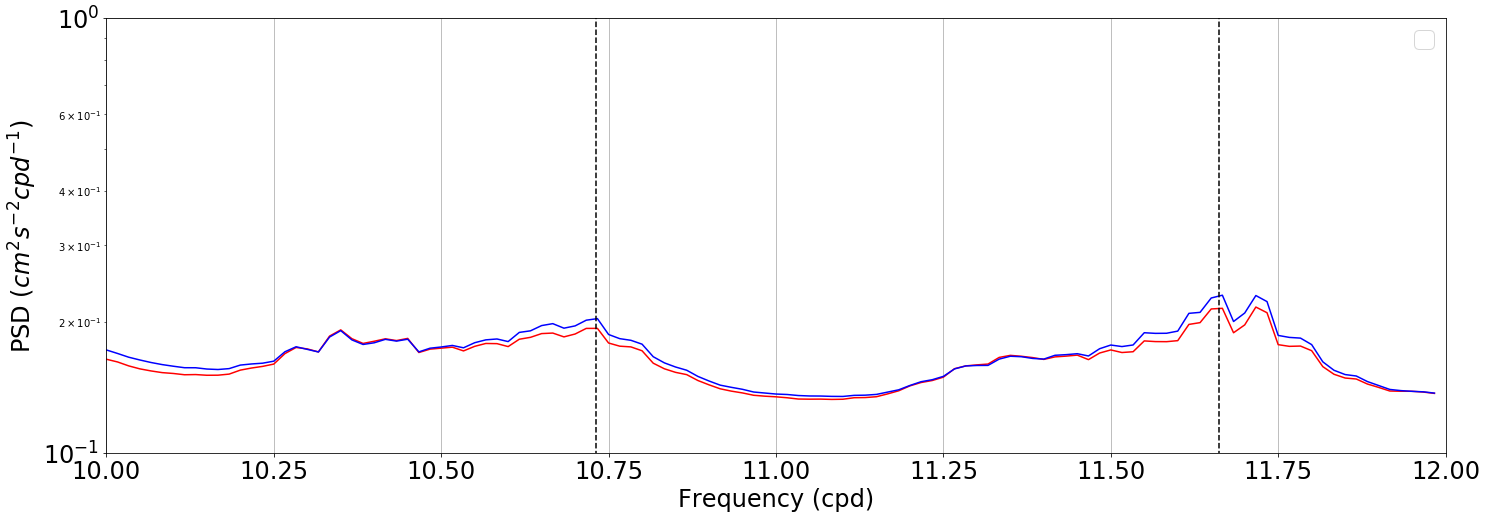

In [34]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(E0_cycl.where(E0_cycl.freq_time>0)).plot(ax=ax,color='red')
(E0_anti.where(E0_anti.freq_time>0)).plot(ax=ax,color='blue')

ax.legend(); ax.grid()
ax.set_yscale('log')
#ax.set_ylim([-0.5,4.5])
#ax.set_yticks([-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5])

ax.set_xlim([10.,12.])
ax.set_ylim([1e-1,1e0])


#ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('')

# Diurnal frequencies
ax.plot([24/25.81933871,24/25.81933871],[1e-2,1e6],'k--') # O1
ax.plot([1,1],[1e-2,1e6],'k--') # S1

# Semi-diurnal frequencies
ax.plot([1.93227,1.93227],[1e-2,1e6],'k--') # M2
ax.plot([2,2],[1e-2,1e6],'k--') # S2

# 3
ax.plot([2.86181,2.86181],[1e-2,1e6],'k--') # MO3
ax.plot([2.93501,2.93501],[1e-2,1e6],'k--') # MK3
ax.plot([3.00274,3.00274],[1e-2,1e6],'k--') # SK3

# 4
ax.plot([3.86455,3.86455],[1e-2,1e6],'k--') # M4
ax.plot([3.93227,3.93227],[1e-2,1e6],'k--') # MS4
ax.plot([4,4],[1e-2,1e6],'k--') # S4

# 5
ax.plot([4.79956,4.79956],[1e-2,1e6],'k--') # 3MP5
ax.plot([4.86729,4.86729],[1e-2,1e6],'k--') # 2MK5
ax.plot([4.93501,4.93501],[1e-2,1e6],'k--') # MSK5

# 6
ax.plot([5.79682,5.79682],[1e-2,1e6],'k--') # M6
ax.plot([5.86455,5.86455],[1e-2,1e6],'k--') # 2MS6
ax.plot([5.93227,5.93227],[1e-2,1e6],'k--') # 2SM6

# 7
ax.plot([6.79956,6.79956],[1e-2,1e6],'k--') # 3MK7
ax.plot([6.86729,6.86729],[1e-2,1e6],'k--') # ST17

# 8
ax.plot([7.72909,7.72909],[1e-2,1e6],'k--') # M8
ax.plot([7.8023,7.8023],[1e-2,1e6],'k--')   # 3MK8
ax.plot([7.86455,7.86455],[1e-2,1e6],'k--') # ST23

# 9
ax.plot([8.73183,8.73183],[1e-2,1e6],'k--') # M4MK9
ax.plot([8.79956,8.79956],[1e-2,1e6],'k--') # ST27


# 10
ax.plot([9.72909,9.72909],[1e-2,1e6],'k--') # ST30
ax.plot([9.79682,9.79682],[1e-2,1e6],'k--') # ST32

# 11
ax.plot([10.7318,10.7318],[1e-2,1e6],'k--') # ST33


# 12
ax.plot([11.6614,11.6614],[1e-2,1e6],'k--') # ST34

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Globally_averaged_PSD_nowindow_4.png')



## 3.3 Read results and plot figures_open oceans

In [21]:
face =1 

filenames_u = sorted(glob(E_dir+'E_uv_south_allmean_openocean.nc'))

# Grid #
grid = mgrid.isel(face=face)
# Read SSU #
ds = xr.open_mfdataset(filenames_u)
print(ds)

<xarray.Dataset>
Dimensions:                        (freq_time: 1440)
Coordinates:
  * freq_time                      (freq_time) float64 0.0 1.929e-07 ...
    freq_time_spacing              float64 ...
Data variables:
    __xarray_dataarray_variable__  (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>


In [22]:
E_south = ds.__xarray_dataarray_variable__
E_south = E_south.assign_coords(freq_time=ds.__xarray_dataarray_variable__.freq_time * 86400.) 
print(E_south)

<xarray.DataArray '__xarray_dataarray_variable__' (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...


In [23]:
E0_south = E_south/8.64

In [24]:
#filenames_u = sorted(glob(E_dir+'E_uv_allface_mean.nc'))
filenames_u = sorted(glob(E_dir+'E_uv_north_allmean_openocean.nc'))

# Grid #
grid = mgrid.isel(face=face)
# Read SSU #
ds0 = xr.open_mfdataset(filenames_u)
print(ds0)

<xarray.Dataset>
Dimensions:                        (freq_time: 1440)
Coordinates:
  * freq_time                      (freq_time) float64 0.0 1.929e-07 ...
    freq_time_spacing              float64 ...
Data variables:
    __xarray_dataarray_variable__  (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>


In [25]:
E_north = ds0.__xarray_dataarray_variable__
E_north = E_north.assign_coords(freq_time=ds0.__xarray_dataarray_variable__.freq_time * 86400.) 
print(E_north)

<xarray.DataArray '__xarray_dataarray_variable__' (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...


In [26]:
E0_north = E_north/8.64

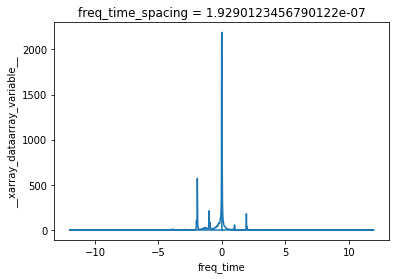

In [27]:
E0_north.plot()

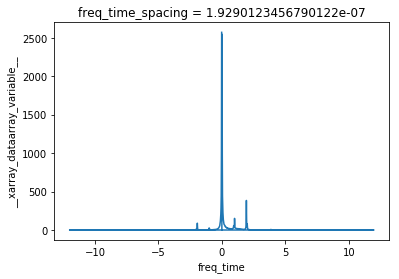

In [28]:
E0_south.plot()

In [29]:
E0_south_anti = E0_south.where(E0_south.freq_time>0)
print(E0_south_anti)

E0_north_anti = E0_north.where(E0_north.freq_time<0)
E0_north_anti = E0_north_anti.assign_coords(freq_time=E_north.freq_time * -1.) 
print(E0_north_anti)

<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07
<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 -0.01667 -0.03333 -0.05 ...
    freq_time_spacing  float64 ...


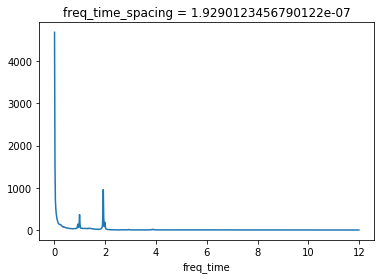

In [30]:
E0_anti = E0_north_anti + E0_south_anti
E0_anti.plot()

In [31]:
E0_south_cycl = E0_south.where(E0_south.freq_time<0)
print(E0_south_cycl)

E0_north_cycl = E0_north.where(E0_north.freq_time>0)
E0_north_cycl = E0_north_cycl.assign_coords(freq_time=E_north.freq_time * -1.) 
print(E0_north_cycl)

<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07
<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 -0.01667 -0.03333 -0.05 ...
    freq_time_spacing  float64 ...


In [32]:
E0_cycl = E0_north_cycl + E0_south_cycl
E0_cycl = E0_cycl.assign_coords(freq_time=E0_cycl.freq_time * -1.) 

print(E0_cycl)

<xarray.DataArray (freq_time: 1439)>
dask.array<shape=(1439,), dtype=float64, chunksize=(1439,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07


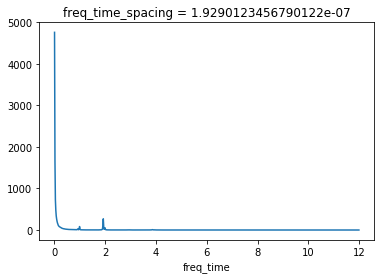

In [33]:
E0_cycl.plot()

In [34]:
E_cycl_open = E0_cycl
E_anti_open = E0_anti

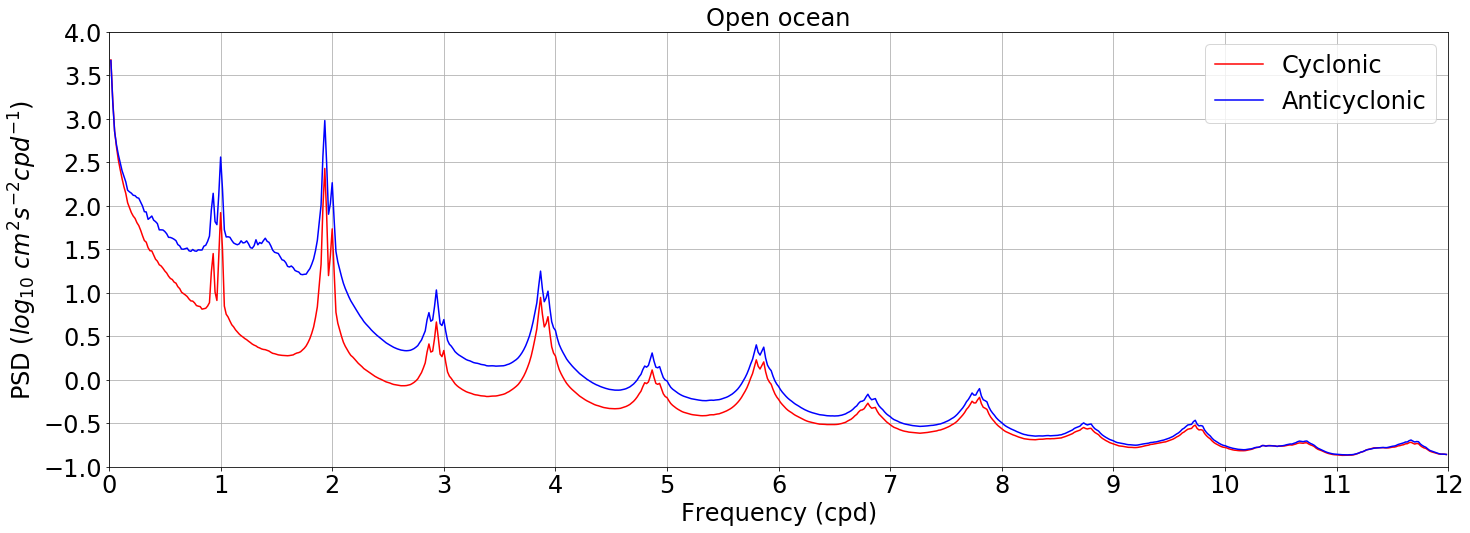

In [35]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(np.log10(E_cycl_open).where(E_cycl_open.freq_time>0)).plot(ax=ax,color='red', label=labels[0])
(np.log10(E_anti_open).where(E_anti_open.freq_time>0)).plot(ax=ax,color='blue', label=labels[1])

ax.legend(); ax.grid()

#ax.set_yscale('log')
ax.set_ylim([-1.,4.])
ax.set_yticks([-1., -0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4])

ax.set_xlim([0.,12.])
#ax.set_ylim([1e-1,1e4])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])

ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Open ocean',fontsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Globally_averaged_PSD_openocean.png')



#### The world oceans vs open ocean

No handles with labels found to put in legend.
No handles with labels found to put in legend.


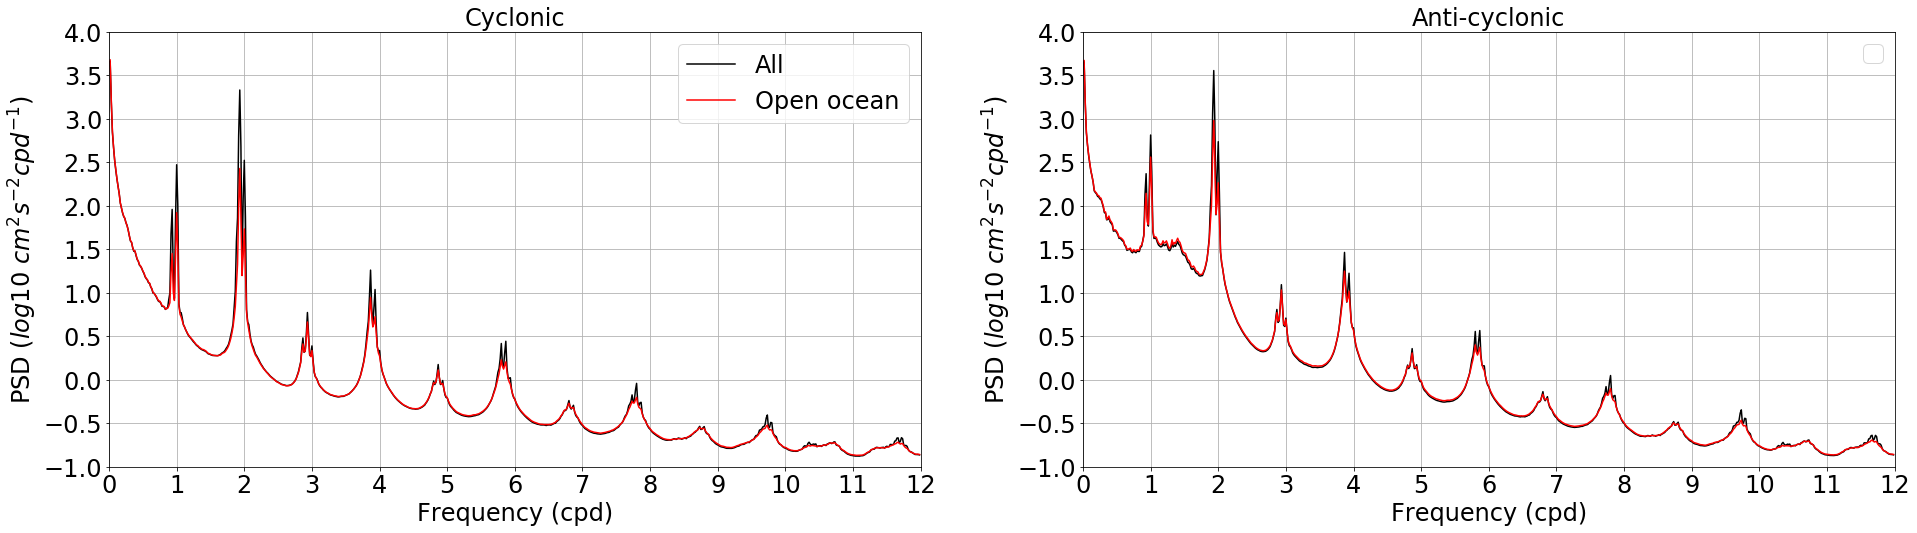

In [69]:

fig = plt.subplots(figsize=(32,8))


ax=plt.subplot(121)


labels = ['All', 'Open ocean']

(np.log10(E_cycl_all).where(E_cycl_all.freq_time>0)).plot(ax=ax,color='black', label=labels[0])
(np.log10(E_cycl_open).where(E_cycl_open.freq_time>0)).plot(ax=ax,color='red', label=labels[1])

ax.legend(); ax.grid()
#ax.set_yscale('log')
ax.set_ylim([-1.,4.])
ax.set_yticks([-1., -0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4])
ax.set_xlim([0.,12.])
#ax.set_ylim([1e-1,1e4])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log10\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)

ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Cyclonic',fontsize=24)


ax=plt.subplot(122)

(np.log10(E_anti_all).where(E_anti_all.freq_time>0)).plot(ax=ax,color='black')
(np.log10(E_anti_open).where(E_anti_open.freq_time>0)).plot(ax=ax,color='red')

ax.legend(); ax.grid()
#ax.set_yscale('log')
ax.set_ylim([-1.,4.])
ax.set_yticks([-1., -0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4])
ax.set_xlim([0.,12.])
#ax.set_ylim([1e-1,1e4])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log10\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)

ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Anti-cyclonic',fontsize=24)


plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Globally_averaged_PSD_comparison.png')



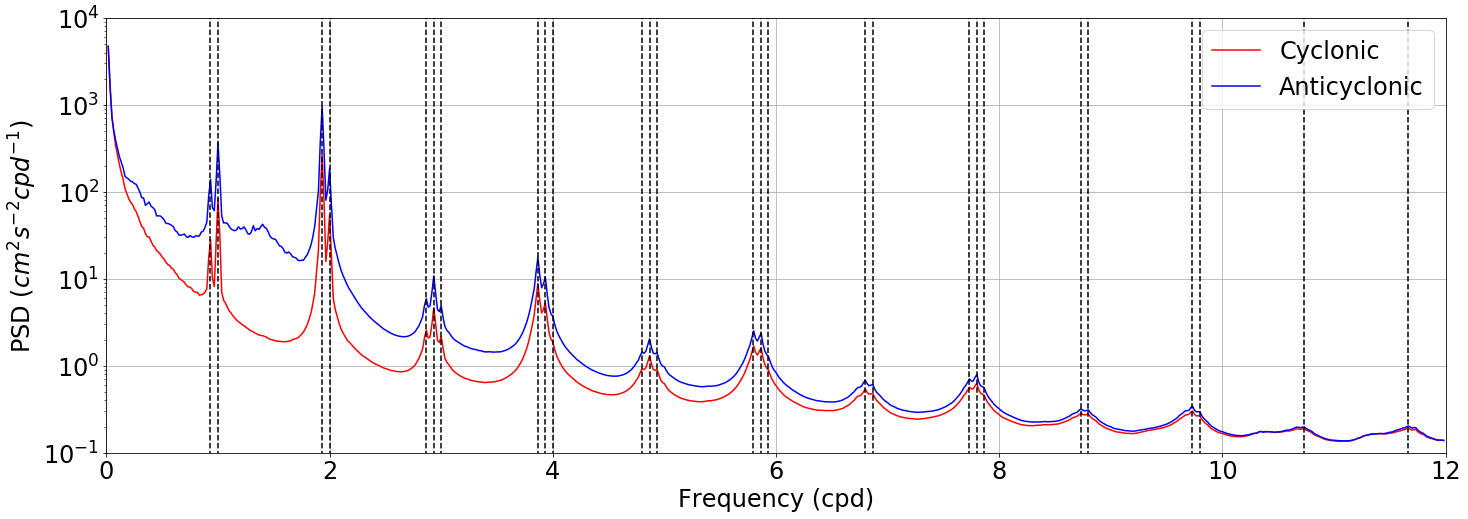

In [37]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(E_cycl_open.where(E_cycl_open.freq_time>0)).plot(ax=ax,color='red', label=labels[0])
(E_anti_open.where(E_anti_open.freq_time>0)).plot(ax=ax,color='blue', label=labels[1])

ax.legend(); ax.grid()
ax.set_yscale('log')
#ax.set_ylim([-0.5,4.5])
#ax.set_yticks([-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5])

ax.set_xlim([0.,12.])
ax.set_ylim([1e-1,1e4])


#ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('')

# Diurnal frequencies
ax.plot([24/25.81933871,24/25.81933871],[1e-2,1e6],'k--') # O1
ax.plot([1,1],[1e-2,1e6],'k--') # S1

# Semi-diurnal frequencies
ax.plot([1.93227,1.93227],[1e-2,1e6],'k--') # M2
ax.plot([2,2],[1e-2,1e6],'k--') # S2

# 3
ax.plot([2.86181,2.86181],[1e-2,1e6],'k--') # MO3
ax.plot([2.93501,2.93501],[1e-2,1e6],'k--') # MK3
ax.plot([3.00274,3.00274],[1e-2,1e6],'k--') # SK3

# 4
ax.plot([3.86455,3.86455],[1e-2,1e6],'k--') # M4
ax.plot([3.93227,3.93227],[1e-2,1e6],'k--') # MS4
ax.plot([4,4],[1e-2,1e6],'k--') # S4

# 5
ax.plot([4.79956,4.79956],[1e-2,1e6],'k--') # 3MP5
ax.plot([4.86729,4.86729],[1e-2,1e6],'k--') # 2MK5
ax.plot([4.93501,4.93501],[1e-2,1e6],'k--') # MSK5

# 6
ax.plot([5.79682,5.79682],[1e-2,1e6],'k--') # M6
ax.plot([5.86455,5.86455],[1e-2,1e6],'k--') # 2MS6
ax.plot([5.93227,5.93227],[1e-2,1e6],'k--') # 2SM6

# 7
ax.plot([6.79956,6.79956],[1e-2,1e6],'k--') # 3MK7
ax.plot([6.86729,6.86729],[1e-2,1e6],'k--') # ST17

# 8
ax.plot([7.72909,7.72909],[1e-2,1e6],'k--') # M8
ax.plot([7.8023,7.8023],[1e-2,1e6],'k--')   # 3MK8
ax.plot([7.86455,7.86455],[1e-2,1e6],'k--') # ST23

# 9
ax.plot([8.73183,8.73183],[1e-2,1e6],'k--') # M4MK9
ax.plot([8.79956,8.79956],[1e-2,1e6],'k--') # ST27


# 10
ax.plot([9.72909,9.72909],[1e-2,1e6],'k--') # ST30
ax.plot([9.79682,9.79682],[1e-2,1e6],'k--') # ST32

# 11
ax.plot([10.7318,10.7318],[1e-2,1e6],'k--') # ST33


# 12
ax.plot([11.6614,11.6614],[1e-2,1e6],'k--') # ST34

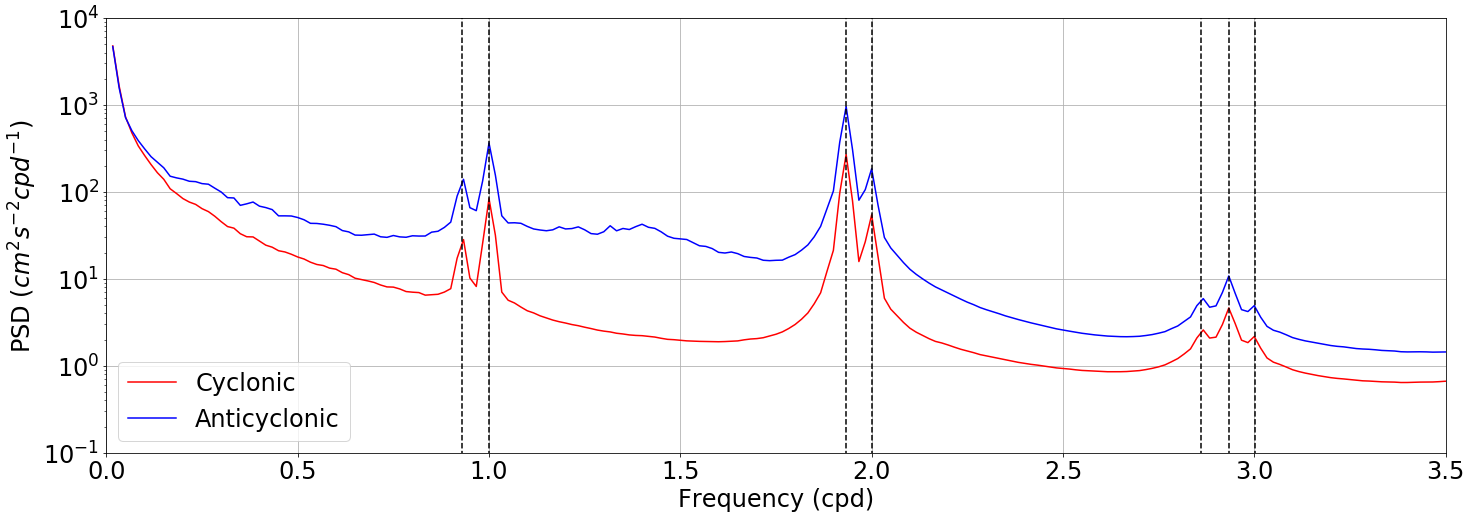

In [38]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(E_cycl_open.where(E_cycl_open.freq_time>0)).plot(ax=ax,color='red', label=labels[0])
(E_anti_open.where(E_anti_open.freq_time>0)).plot(ax=ax,color='blue', label=labels[1])

ax.legend(); ax.grid()
ax.set_yscale('log')
#ax.set_ylim([-0.5,4.5])
#ax.set_yticks([-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5])

ax.set_xlim([0.,3.5])
ax.set_ylim([1e-1,1e4])


#ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('')

# Diurnal frequencies
ax.plot([24/25.81933871,24/25.81933871],[1e-2,1e6],'k--') # O1
ax.plot([1,1],[1e-2,1e6],'k--') # S1

# Semi-diurnal frequencies
ax.plot([1.93227,1.93227],[1e-2,1e6],'k--') # M2
ax.plot([2,2],[1e-2,1e6],'k--') # S2

# 3
ax.plot([2.86181,2.86181],[1e-2,1e6],'k--') # MO3
ax.plot([2.93501,2.93501],[1e-2,1e6],'k--') # MK3
ax.plot([3.00274,3.00274],[1e-2,1e6],'k--') # SK3

# 4
ax.plot([3.86455,3.86455],[1e-2,1e6],'k--') # M4
ax.plot([3.93227,3.93227],[1e-2,1e6],'k--') # MS4
ax.plot([4,4],[1e-2,1e6],'k--') # S4

# 5
ax.plot([4.79956,4.79956],[1e-2,1e6],'k--') # 3MP5
ax.plot([4.86729,4.86729],[1e-2,1e6],'k--') # 2MK5
ax.plot([4.93501,4.93501],[1e-2,1e6],'k--') # MSK5

# 6
ax.plot([5.79682,5.79682],[1e-2,1e6],'k--') # M6
ax.plot([5.86455,5.86455],[1e-2,1e6],'k--') # 2MS6
ax.plot([5.93227,5.93227],[1e-2,1e6],'k--') # 2SM6

# 7
ax.plot([6.79956,6.79956],[1e-2,1e6],'k--') # 3MK7
ax.plot([6.86729,6.86729],[1e-2,1e6],'k--') # ST17

# 8
ax.plot([7.72909,7.72909],[1e-2,1e6],'k--') # M8
ax.plot([7.8023,7.8023],[1e-2,1e6],'k--')   # 3MK8
ax.plot([7.86455,7.86455],[1e-2,1e6],'k--') # ST23

# 9
ax.plot([8.73183,8.73183],[1e-2,1e6],'k--') # M4MK9
ax.plot([8.79956,8.79956],[1e-2,1e6],'k--') # ST27


# 10
ax.plot([9.72909,9.72909],[1e-2,1e6],'k--') # ST30
ax.plot([9.79682,9.79682],[1e-2,1e6],'k--') # ST32

# 11
ax.plot([10.7318,10.7318],[1e-2,1e6],'k--') # ST33


# 12
ax.plot([11.6614,11.6614],[1e-2,1e6],'k--') # ST34

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Globally_averaged_PSD_nowindow_1.png')



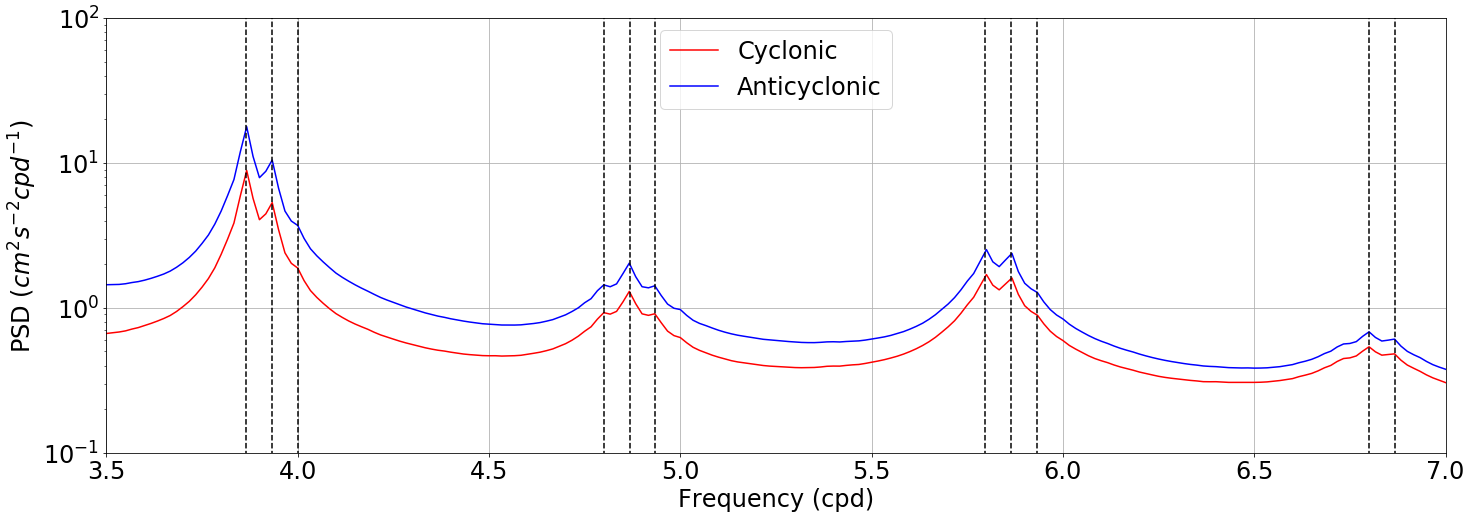

In [39]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(E_cycl_open.where(E_cycl_open.freq_time>0)).plot(ax=ax,color='red', label=labels[0])
(E_anti_open.where(E_anti_open.freq_time>0)).plot(ax=ax,color='blue', label=labels[1])

ax.legend(); ax.grid()
ax.set_yscale('log')
#ax.set_ylim([-0.5,4.5])
#ax.set_yticks([-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5])

ax.set_xlim([3.5,7.])
ax.set_ylim([1e-1,1e2])


#ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('')

# Diurnal frequencies
ax.plot([24/25.81933871,24/25.81933871],[1e-2,1e6],'k--') # O1
ax.plot([1,1],[1e-2,1e6],'k--') # S1

# Semi-diurnal frequencies
ax.plot([1.93227,1.93227],[1e-2,1e6],'k--') # M2
ax.plot([2,2],[1e-2,1e6],'k--') # S2

# 3
ax.plot([2.86181,2.86181],[1e-2,1e6],'k--') # MO3
ax.plot([2.93501,2.93501],[1e-2,1e6],'k--') # MK3
ax.plot([3.00274,3.00274],[1e-2,1e6],'k--') # SK3

# 4
ax.plot([3.86455,3.86455],[1e-2,1e6],'k--') # M4
ax.plot([3.93227,3.93227],[1e-2,1e6],'k--') # MS4
ax.plot([4,4],[1e-2,1e6],'k--') # S4

# 5
ax.plot([4.79956,4.79956],[1e-2,1e6],'k--') # 3MP5
ax.plot([4.86729,4.86729],[1e-2,1e6],'k--') # 2MK5
ax.plot([4.93501,4.93501],[1e-2,1e6],'k--') # MSK5

# 6
ax.plot([5.79682,5.79682],[1e-2,1e6],'k--') # M6
ax.plot([5.86455,5.86455],[1e-2,1e6],'k--') # 2MS6
ax.plot([5.93227,5.93227],[1e-2,1e6],'k--') # 2SM6

# 7
ax.plot([6.79956,6.79956],[1e-2,1e6],'k--') # 3MK7
ax.plot([6.86729,6.86729],[1e-2,1e6],'k--') # ST17

# 8
ax.plot([7.72909,7.72909],[1e-2,1e6],'k--') # M8
ax.plot([7.8023,7.8023],[1e-2,1e6],'k--')   # 3MK8
ax.plot([7.86455,7.86455],[1e-2,1e6],'k--') # ST23

# 9
ax.plot([8.73183,8.73183],[1e-2,1e6],'k--') # M4MK9
ax.plot([8.79956,8.79956],[1e-2,1e6],'k--') # ST27


# 10
ax.plot([9.72909,9.72909],[1e-2,1e6],'k--') # ST30
ax.plot([9.79682,9.79682],[1e-2,1e6],'k--') # ST32

# 11
ax.plot([10.7318,10.7318],[1e-2,1e6],'k--') # ST33


# 12
ax.plot([11.6614,11.6614],[1e-2,1e6],'k--') # ST34

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Globally_averaged_PSD_nowindow_2.png')



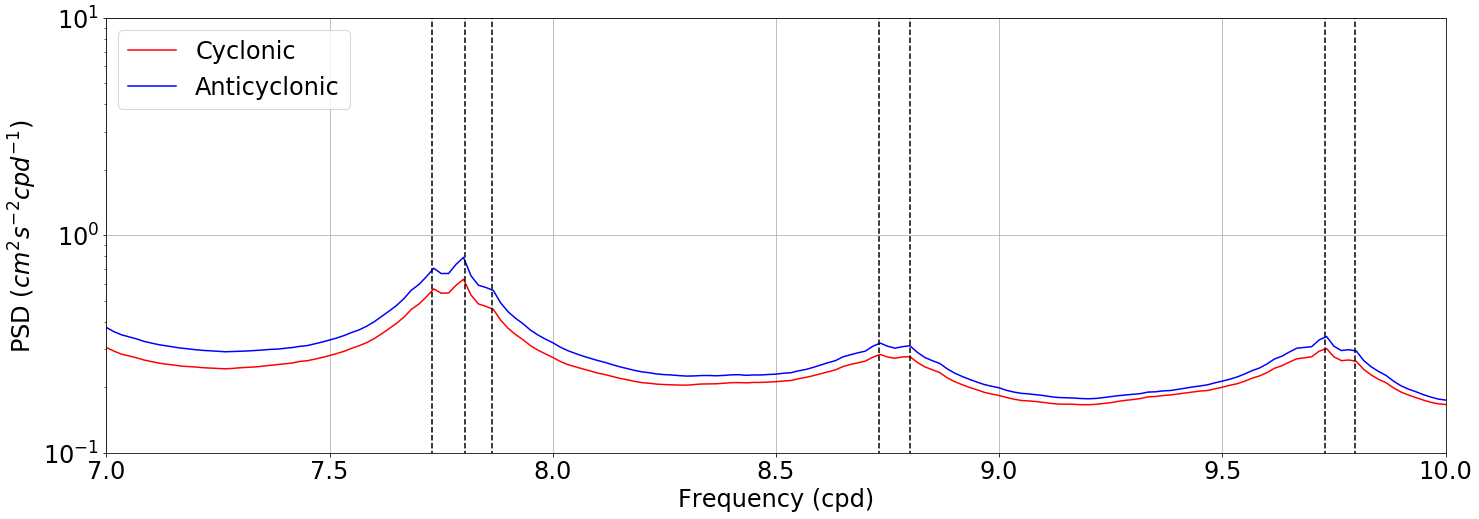

In [40]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(E_cycl_open.where(E_cycl_open.freq_time>0)).plot(ax=ax,color='red', label=labels[0])
(E_anti_open.where(E_anti_open.freq_time>0)).plot(ax=ax,color='blue', label=labels[1])

ax.legend(); ax.grid()
ax.set_yscale('log')
#ax.set_ylim([-0.5,4.5])
#ax.set_yticks([-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5])

ax.set_xlim([7.,10.])
ax.set_ylim([1e-1,1e1])


#ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('')

# Diurnal frequencies
ax.plot([24/25.81933871,24/25.81933871],[1e-2,1e6],'k--') # O1
ax.plot([1,1],[1e-2,1e6],'k--') # S1

# Semi-diurnal frequencies
ax.plot([1.93227,1.93227],[1e-2,1e6],'k--') # M2
ax.plot([2,2],[1e-2,1e6],'k--') # S2

# 3
ax.plot([2.86181,2.86181],[1e-2,1e6],'k--') # MO3
ax.plot([2.93501,2.93501],[1e-2,1e6],'k--') # MK3
ax.plot([3.00274,3.00274],[1e-2,1e6],'k--') # SK3

# 4
ax.plot([3.86455,3.86455],[1e-2,1e6],'k--') # M4
ax.plot([3.93227,3.93227],[1e-2,1e6],'k--') # MS4
ax.plot([4,4],[1e-2,1e6],'k--') # S4

# 5
ax.plot([4.79956,4.79956],[1e-2,1e6],'k--') # 3MP5
ax.plot([4.86729,4.86729],[1e-2,1e6],'k--') # 2MK5
ax.plot([4.93501,4.93501],[1e-2,1e6],'k--') # MSK5

# 6
ax.plot([5.79682,5.79682],[1e-2,1e6],'k--') # M6
ax.plot([5.86455,5.86455],[1e-2,1e6],'k--') # 2MS6
ax.plot([5.93227,5.93227],[1e-2,1e6],'k--') # 2SM6

# 7
ax.plot([6.79956,6.79956],[1e-2,1e6],'k--') # 3MK7
ax.plot([6.86729,6.86729],[1e-2,1e6],'k--') # ST17

# 8
ax.plot([7.72909,7.72909],[1e-2,1e6],'k--') # M8
ax.plot([7.8023,7.8023],[1e-2,1e6],'k--')   # 3MK8
ax.plot([7.86455,7.86455],[1e-2,1e6],'k--') # ST23

# 9
ax.plot([8.73183,8.73183],[1e-2,1e6],'k--') # M4MK9
ax.plot([8.79956,8.79956],[1e-2,1e6],'k--') # ST27


# 10
ax.plot([9.72909,9.72909],[1e-2,1e6],'k--') # ST30
ax.plot([9.79682,9.79682],[1e-2,1e6],'k--') # ST32

# 11
ax.plot([10.7318,10.7318],[1e-2,1e6],'k--') # ST33


# 12
ax.plot([11.6614,11.6614],[1e-2,1e6],'k--') # ST34

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Globally_averaged_PSD_nowindow_3.png')



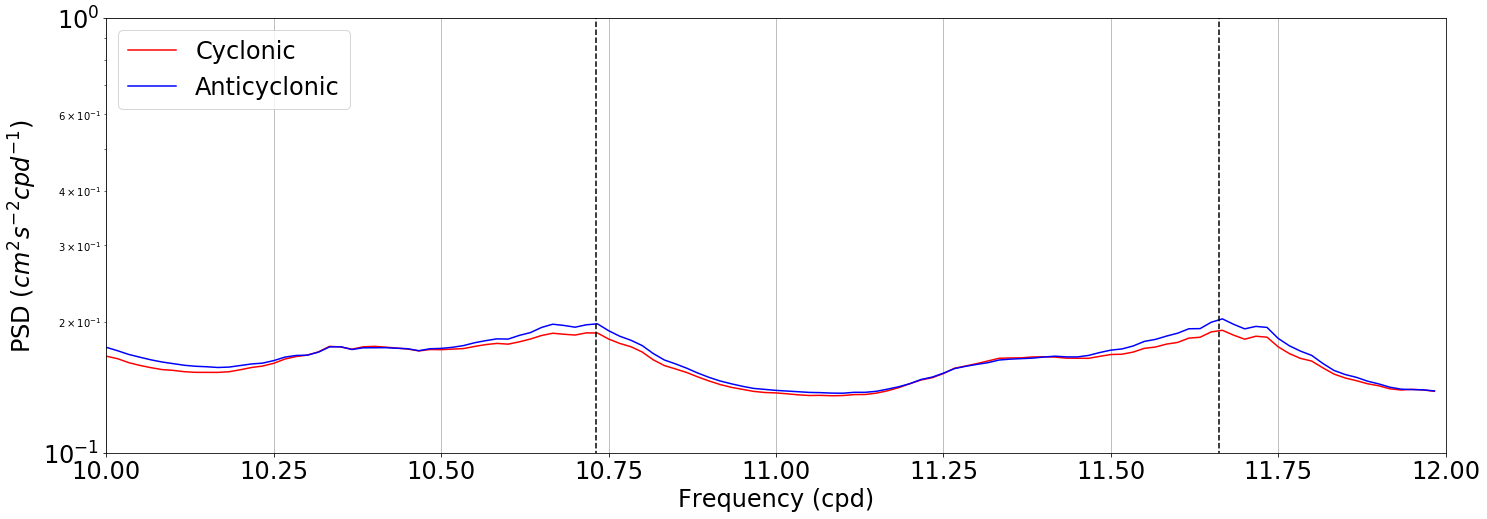

In [41]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']


(E_cycl_open.where(E_cycl_open.freq_time>0)).plot(ax=ax,color='red', label=labels[0])
(E_anti_open.where(E_anti_open.freq_time>0)).plot(ax=ax,color='blue', label=labels[1])

ax.legend(); ax.grid()
ax.set_yscale('log')
#ax.set_ylim([-0.5,4.5])
#ax.set_yticks([-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5])

ax.set_xlim([10.,12.])
ax.set_ylim([1e-1,1e0])


#ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('')

# Diurnal frequencies
ax.plot([24/25.81933871,24/25.81933871],[1e-2,1e6],'k--') # O1
ax.plot([1,1],[1e-2,1e6],'k--') # S1

# Semi-diurnal frequencies
ax.plot([1.93227,1.93227],[1e-2,1e6],'k--') # M2
ax.plot([2,2],[1e-2,1e6],'k--') # S2

# 3
ax.plot([2.86181,2.86181],[1e-2,1e6],'k--') # MO3
ax.plot([2.93501,2.93501],[1e-2,1e6],'k--') # MK3
ax.plot([3.00274,3.00274],[1e-2,1e6],'k--') # SK3

# 4
ax.plot([3.86455,3.86455],[1e-2,1e6],'k--') # M4
ax.plot([3.93227,3.93227],[1e-2,1e6],'k--') # MS4
ax.plot([4,4],[1e-2,1e6],'k--') # S4

# 5
ax.plot([4.79956,4.79956],[1e-2,1e6],'k--') # 3MP5
ax.plot([4.86729,4.86729],[1e-2,1e6],'k--') # 2MK5
ax.plot([4.93501,4.93501],[1e-2,1e6],'k--') # MSK5

# 6
ax.plot([5.79682,5.79682],[1e-2,1e6],'k--') # M6
ax.plot([5.86455,5.86455],[1e-2,1e6],'k--') # 2MS6
ax.plot([5.93227,5.93227],[1e-2,1e6],'k--') # 2SM6

# 7
ax.plot([6.79956,6.79956],[1e-2,1e6],'k--') # 3MK7
ax.plot([6.86729,6.86729],[1e-2,1e6],'k--') # ST17

# 8
ax.plot([7.72909,7.72909],[1e-2,1e6],'k--') # M8
ax.plot([7.8023,7.8023],[1e-2,1e6],'k--')   # 3MK8
ax.plot([7.86455,7.86455],[1e-2,1e6],'k--') # ST23

# 9
ax.plot([8.73183,8.73183],[1e-2,1e6],'k--') # M4MK9
ax.plot([8.79956,8.79956],[1e-2,1e6],'k--') # ST27


# 10
ax.plot([9.72909,9.72909],[1e-2,1e6],'k--') # ST30
ax.plot([9.79682,9.79682],[1e-2,1e6],'k--') # ST32

# 11
ax.plot([10.7318,10.7318],[1e-2,1e6],'k--') # ST33


# 12
ax.plot([11.6614,11.6614],[1e-2,1e6],'k--') # ST34

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Globally_averaged_PSD_nowindow_4.png')



## 3.4 Read results and plot figures_coastal oceans

In [42]:
face =1 

filenames_u = sorted(glob(E_dir+'E_uv_south_allmean_coastalocean.nc'))

# Grid #
grid = mgrid.isel(face=face)
# Read SSU #
ds = xr.open_mfdataset(filenames_u)
print(ds)

<xarray.Dataset>
Dimensions:                        (freq_time: 1440)
Coordinates:
  * freq_time                      (freq_time) float64 0.0 1.929e-07 ...
    freq_time_spacing              float64 ...
Data variables:
    __xarray_dataarray_variable__  (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>


In [43]:
E_south = ds.__xarray_dataarray_variable__
E_south = E_south.assign_coords(freq_time=ds.__xarray_dataarray_variable__.freq_time * 86400.) 
print(E_south)

<xarray.DataArray '__xarray_dataarray_variable__' (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...


In [44]:
E0_south = E_south/8.64

In [45]:
#filenames_u = sorted(glob(E_dir+'E_uv_allface_mean.nc'))
filenames_u = sorted(glob(E_dir+'E_uv_north_allmean_coastalocean.nc'))

# Grid #
grid = mgrid.isel(face=face)
# Read SSU #
ds0 = xr.open_mfdataset(filenames_u)
print(ds0)

<xarray.Dataset>
Dimensions:                        (freq_time: 1440)
Coordinates:
  * freq_time                      (freq_time) float64 0.0 1.929e-07 ...
    freq_time_spacing              float64 ...
Data variables:
    __xarray_dataarray_variable__  (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>


In [46]:
E_north = ds0.__xarray_dataarray_variable__
E_north = E_north.assign_coords(freq_time=ds0.__xarray_dataarray_variable__.freq_time * 86400.) 
print(E_north)

<xarray.DataArray '__xarray_dataarray_variable__' (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...


In [47]:
E0_north = E_north/8.64

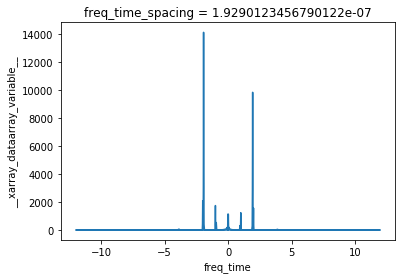

In [48]:
E0_north.plot()

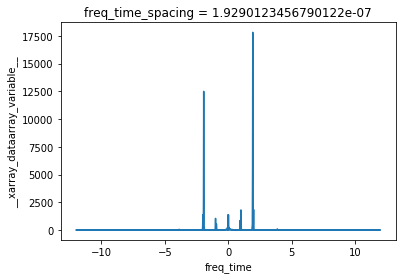

In [49]:
E0_south.plot()

In [50]:
E0_south_anti = E0_south.where(E0_south.freq_time>0)
print(E0_south_anti)

E0_north_anti = E0_north.where(E0_north.freq_time<0)
E0_north_anti = E0_north_anti.assign_coords(freq_time=E_north.freq_time * -1.) 
print(E0_north_anti)

<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07
<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 -0.01667 -0.03333 -0.05 ...
    freq_time_spacing  float64 ...


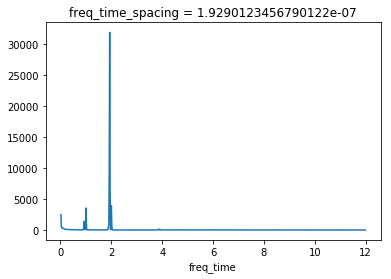

In [51]:
E0_anti = E0_north_anti + E0_south_anti
E0_anti.plot()

In [52]:
E0_south_cycl = E0_south.where(E0_south.freq_time<0)
print(E0_south_cycl)

E0_north_cycl = E0_north.where(E0_north.freq_time>0)
E0_north_cycl = E0_north_cycl.assign_coords(freq_time=E_north.freq_time * -1.) 
print(E0_north_cycl)

<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07
<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 -0.01667 -0.03333 -0.05 ...
    freq_time_spacing  float64 ...


In [53]:
E0_cycl = E0_north_cycl + E0_south_cycl
E0_cycl = E0_cycl.assign_coords(freq_time=E0_cycl.freq_time * -1.) 

print(E0_cycl)

<xarray.DataArray (freq_time: 1439)>
dask.array<shape=(1439,), dtype=float64, chunksize=(1439,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07


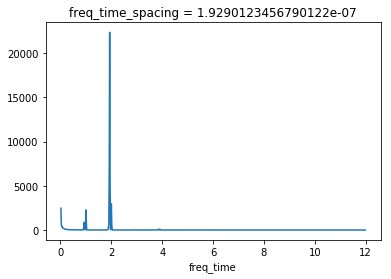

In [54]:
E0_cycl.plot()

In [55]:
E_cycl_coastal = E0_cycl
E_anti_coastal = E0_anti

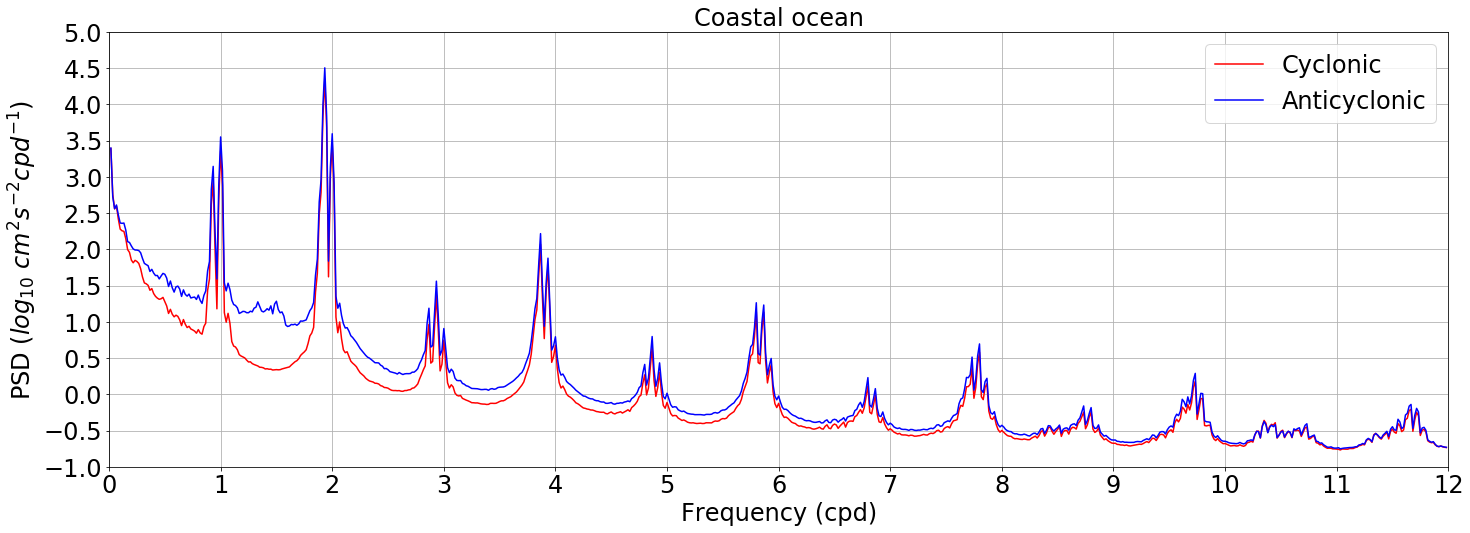

In [56]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(np.log10(E_cycl_coastal).where(E_cycl_coastal.freq_time>0)).plot(ax=ax,color='red', label=labels[0])
(np.log10(E_anti_coastal).where(E_anti_coastal.freq_time>0)).plot(ax=ax,color='blue', label=labels[1])

ax.legend(); ax.grid()

#ax.set_yscale('log')
ax.set_ylim([-1.,5.])
ax.set_yticks([-1., -0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5])

ax.set_xlim([0.,12.])
#ax.set_ylim([1e-1,1e4])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])

ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Coastal ocean',fontsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Globally_averaged_PSD_coastalocean.png')



No handles with labels found to put in legend.
No handles with labels found to put in legend.


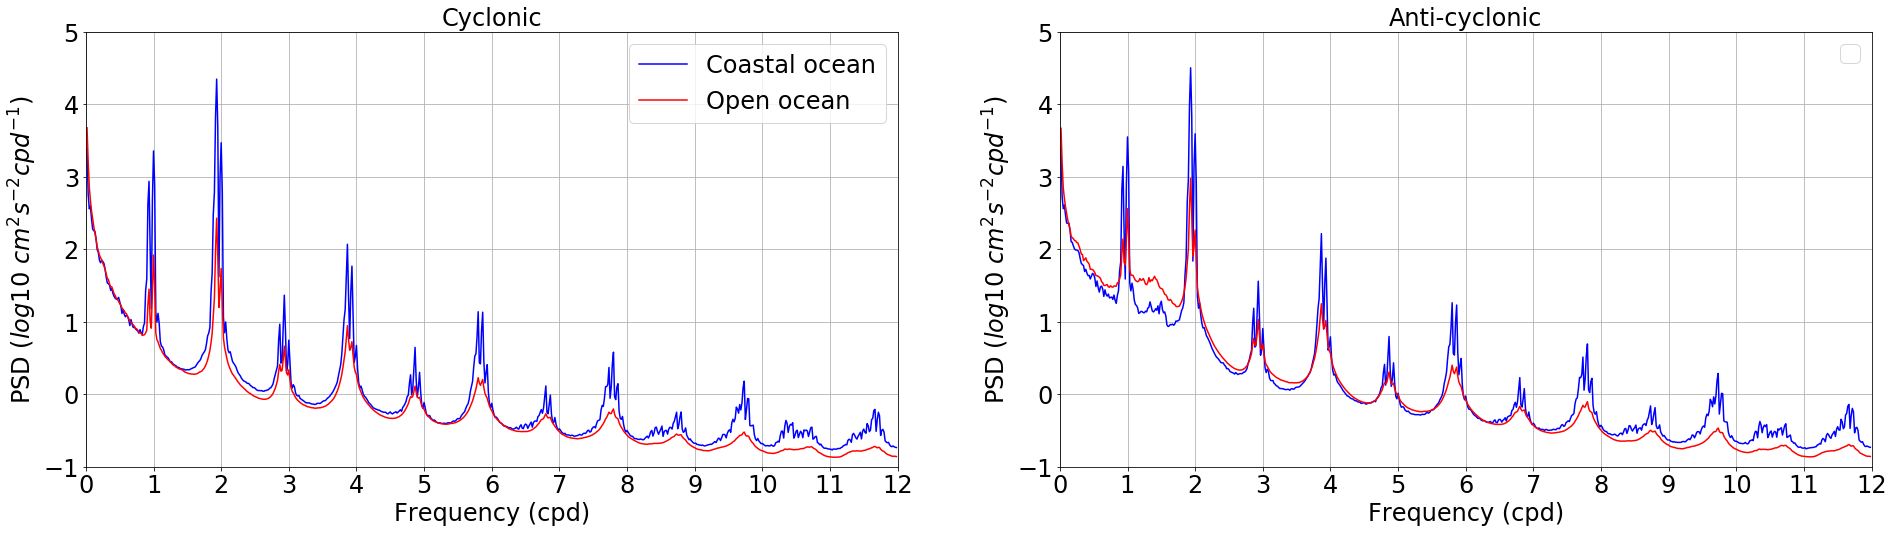

In [68]:

fig = plt.subplots(figsize=(32,8))


ax=plt.subplot(121)


labels = ['Coastal ocean', 'Open ocean']

(np.log10(E_cycl_coastal).where(E_cycl_coastal.freq_time>0)).plot(ax=ax,color='blue', label=labels[0])
(np.log10(E_cycl_open).where(E_cycl_open.freq_time>0)).plot(ax=ax,color='red', label=labels[1])

ax.legend(); ax.grid()
#ax.set_yscale('log')
ax.set_ylim([-1.,5.])
ax.set_yticks([-1., 0., 1., 2., 3., 4, 5])
ax.set_xlim([0.,12.])
#ax.set_ylim([1e-1,1e4])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log10\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)

ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Cyclonic',fontsize=24)


ax=plt.subplot(122)

(np.log10(E_anti_coastal).where(E_anti_coastal.freq_time>0)).plot(ax=ax,color='blue')
(np.log10(E_anti_open).where(E_anti_open.freq_time>0)).plot(ax=ax,color='red')

ax.legend(); ax.grid()
#ax.set_yscale('log')
ax.set_ylim([-1.,5.])
ax.set_yticks([-1., 0., 1., 2., 3., 4, 5])
ax.set_xlim([0.,12.])
#ax.set_ylim([1e-1,1e4])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log10\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)

ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Anti-cyclonic',fontsize=24)


plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Globally_averaged_PSD_coastal_open_comparison.png')



No handles with labels found to put in legend.
No handles with labels found to put in legend.


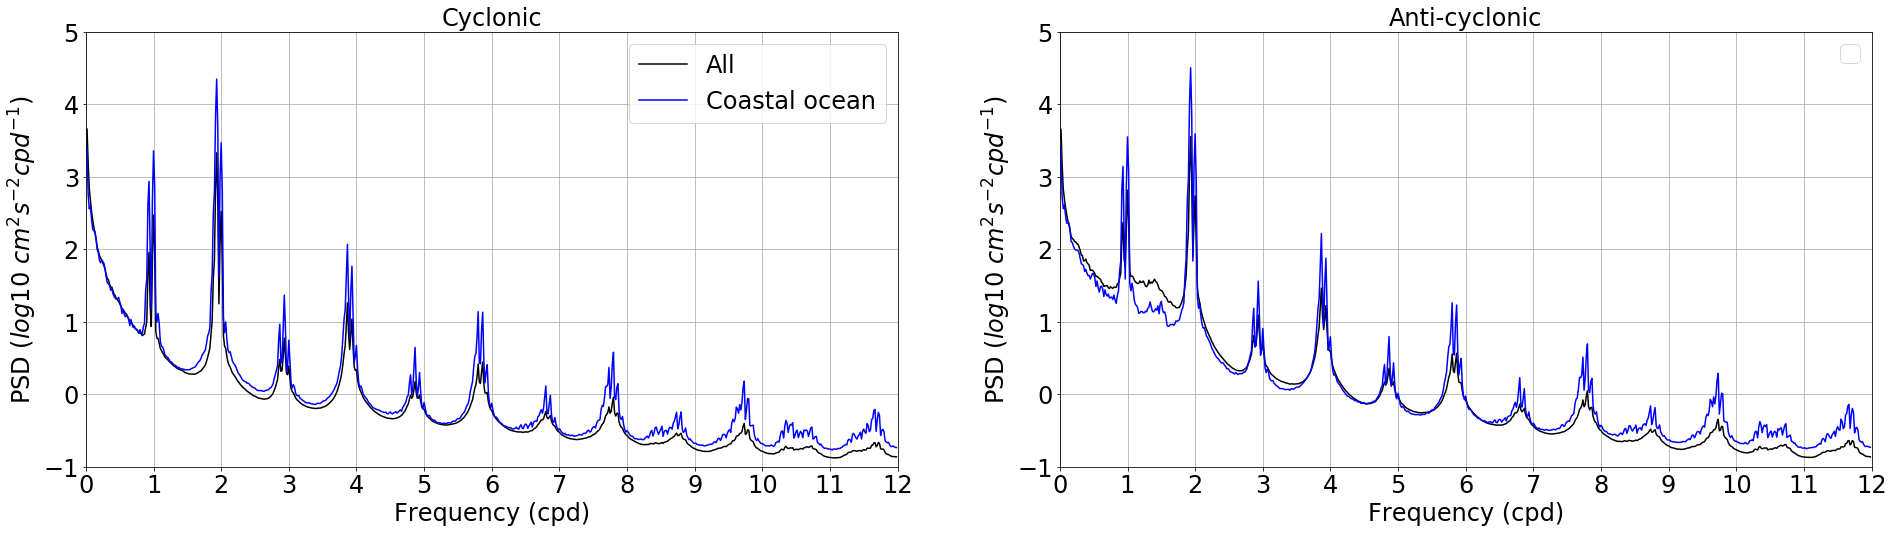

In [67]:

fig = plt.subplots(figsize=(32,8))


ax=plt.subplot(121)


labels = ['All', 'Coastal ocean']

(np.log10(E_cycl_all).where(E_cycl_all.freq_time>0)).plot(ax=ax,color='black', label=labels[0])
(np.log10(E_cycl_coastal).where(E_cycl_coastal.freq_time>0)).plot(ax=ax,color='blue', label=labels[1])

ax.legend(); ax.grid()
#ax.set_yscale('log')
ax.set_ylim([-1.,5.])
ax.set_yticks([-1., 0., 1., 2., 3., 4, 5])
ax.set_xlim([0.,12.])
#ax.set_ylim([1e-1,1e4])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log10\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)

ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Cyclonic',fontsize=24)


ax=plt.subplot(122)

(np.log10(E_anti_all).where(E_anti_all.freq_time>0)).plot(ax=ax,color='black')
(np.log10(E_anti_coastal).where(E_anti_coastal.freq_time>0)).plot(ax=ax,color='blue')

ax.legend(); ax.grid()
#ax.set_yscale('log')
ax.set_ylim([-1.,5.])
ax.set_yticks([-1., 0., 1., 2., 3., 4, 5])
ax.set_xlim([0.,12.])
#ax.set_ylim([1e-1,1e4])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log10\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)

ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Anti-cyclonic',fontsize=24)


plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Globally_averaged_PSD_coastal_all_comparison.png')

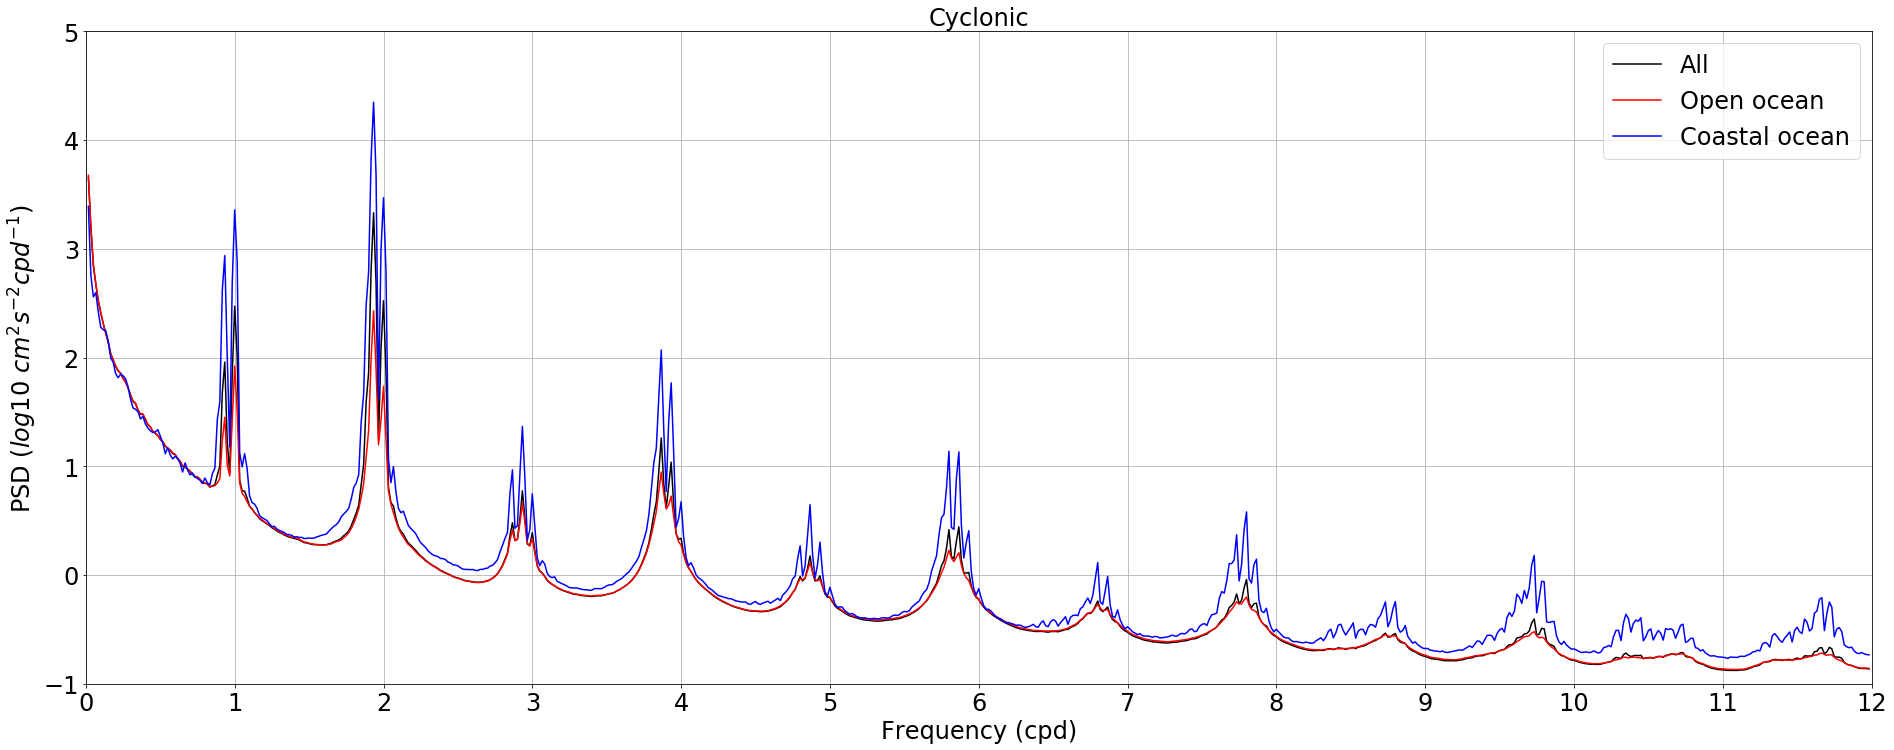

In [66]:

fig = plt.subplots(figsize=(32,12))


ax=plt.subplot(111)


labels = ['All', 'Open ocean', 'Coastal ocean']

(np.log10(E_cycl_all).where(E_cycl_all.freq_time>0)).plot(ax=ax,color='black', label=labels[0])
(np.log10(E_cycl_open).where(E_cycl_open.freq_time>0)).plot(ax=ax,color='red', label=labels[1])
(np.log10(E_cycl_coastal).where(E_cycl_coastal.freq_time>0)).plot(ax=ax,color='blue', label=labels[2])

ax.legend(); ax.grid()
#ax.set_yscale('log')
ax.set_ylim([-1.,5.])
ax.set_yticks([-1., 0., 1., 2., 3., 4, 5])
ax.set_xlim([0.,12.])
#ax.set_ylim([1e-1,1e4])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log10\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Cyclonic',fontsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Globally_averaged_PSD_coastal_open_all_comparison_1.png')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


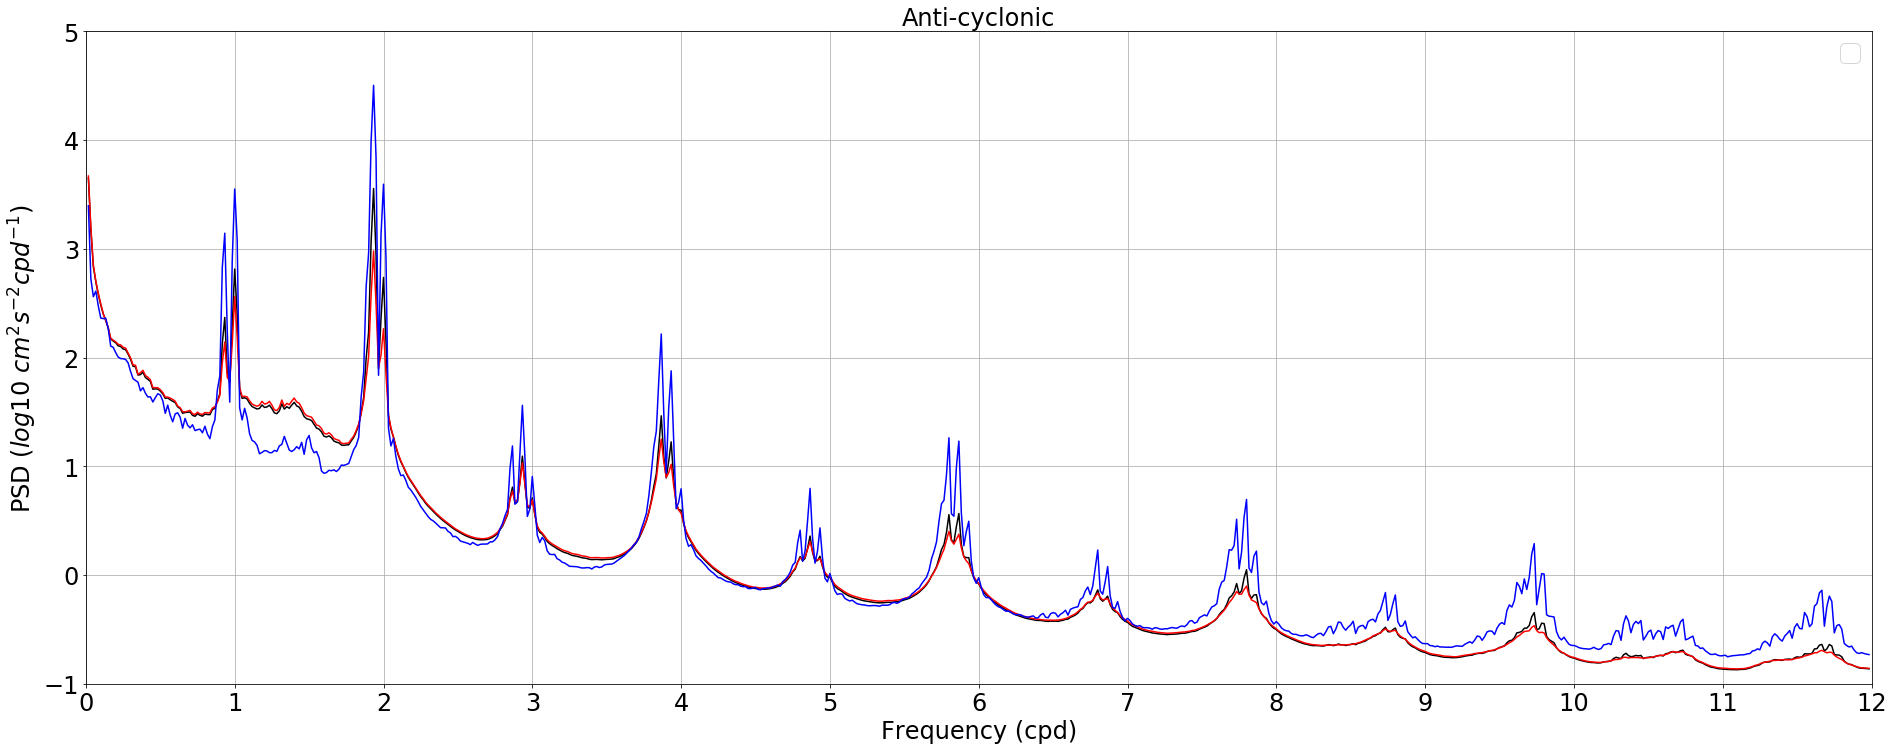

In [65]:

fig = plt.subplots(figsize=(32,12))



ax=plt.subplot(111)

(np.log10(E_anti_all).where(E_anti_all.freq_time>0)).plot(ax=ax,color='black')
(np.log10(E_anti_open).where(E_anti_open.freq_time>0)).plot(ax=ax,color='red')
(np.log10(E_anti_coastal).where(E_anti_coastal.freq_time>0)).plot(ax=ax,color='blue')

ax.legend(); ax.grid()
#ax.set_yscale('log')
ax.set_ylim([-1.,5.])
ax.set_yticks([-1., 0., 1., 2., 3., 4, 5])
ax.set_xlim([0.,12.])
#ax.set_ylim([1e-1,1e4])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log10\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Anti-cyclonic',fontsize=24)


plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Globally_averaged_PSD_coastal_open_all_comparison_2.png')

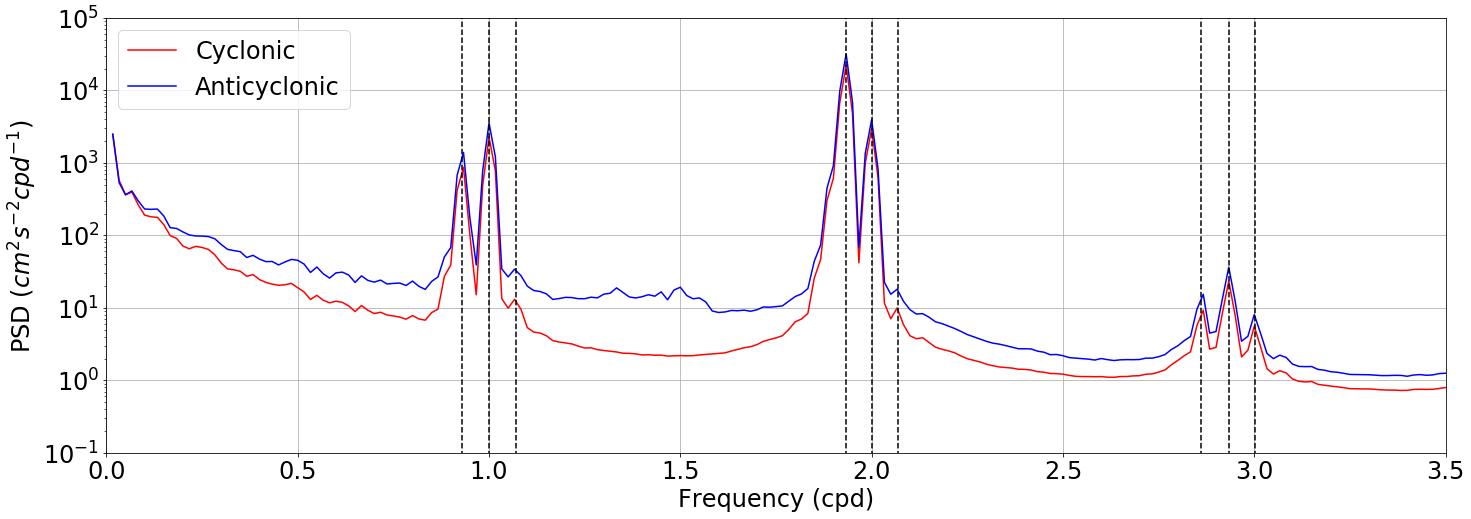

In [78]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(E_cycl_coastal.where(E_cycl_coastal.freq_time>0)).plot(ax=ax,color='red', label=labels[0])
(E_anti_coastal.where(E_anti_coastal.freq_time>0)).plot(ax=ax,color='blue', label=labels[1])

ax.legend(); ax.grid()
ax.set_yscale('log')
#ax.set_ylim([-0.5,4.5])
#ax.set_yticks([-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5])

ax.set_xlim([0.,3.5])
ax.set_ylim([1e-1,1e5])


#ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('')

# Diurnal frequencies
ax.plot([24/25.81933871,24/25.81933871],[1e-2,1e6],'k--') # O1
ax.plot([1,1],[1e-2,1e6],'k--') # S1
ax.plot([1.07046,1.07046],[1e-2,1e6],'k--') # SO1

# Semi-diurnal frequencies
ax.plot([1.93227,1.93227],[1e-2,1e6],'k--') # M2
ax.plot([2,2],[1e-2,1e6],'k--') # S2
ax.plot([2.06773,2.06773],[1e-2,1e6],'k--') # 2SM2




# 3
ax.plot([2.86181,2.86181],[1e-2,1e6],'k--') # MO3
ax.plot([2.93501,2.93501],[1e-2,1e6],'k--') # MK3
ax.plot([3.00274,3.00274],[1e-2,1e6],'k--') # SK3

# 4
ax.plot([3.86455,3.86455],[1e-2,1e6],'k--') # M4
ax.plot([3.93227,3.93227],[1e-2,1e6],'k--') # MS4
ax.plot([4,4],[1e-2,1e6],'k--') # S4


#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Globally_averaged_PSD_nowindow_1.png')



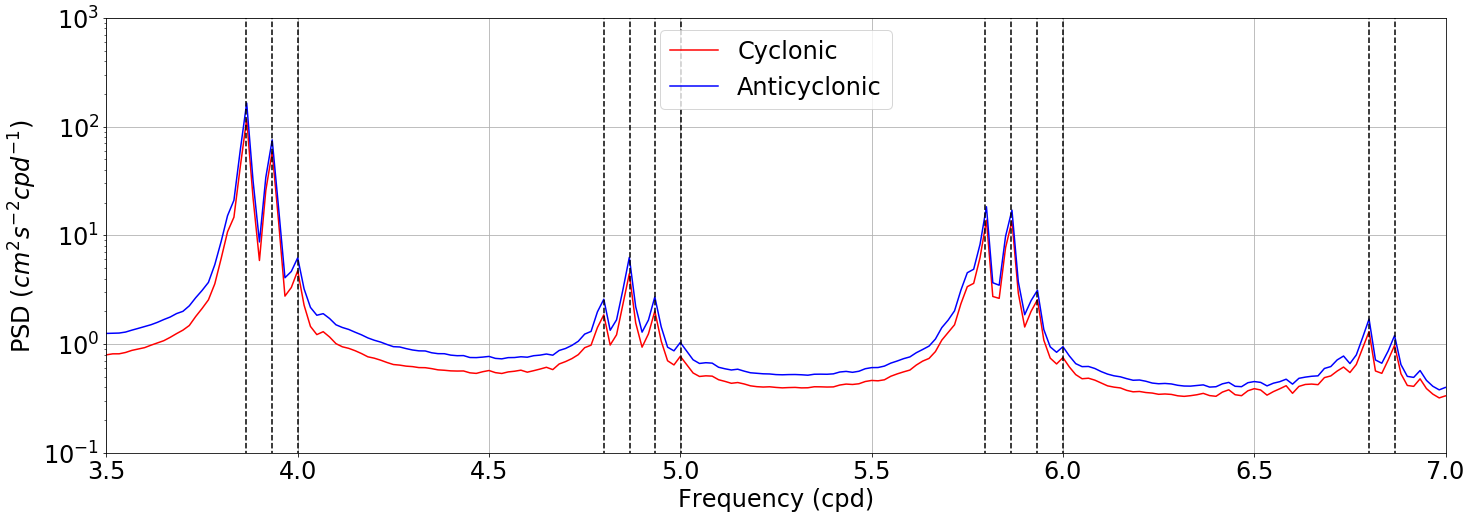

In [80]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(E_cycl_coastal.where(E_cycl_coastal.freq_time>0)).plot(ax=ax,color='red', label=labels[0])
(E_anti_coastal.where(E_anti_coastal.freq_time>0)).plot(ax=ax,color='blue', label=labels[1])

ax.legend(); ax.grid()
ax.set_yscale('log')
#ax.set_ylim([-0.5,4.5])
#ax.set_yticks([-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5])

ax.set_xlim([3.5,7.])
ax.set_ylim([1e-1,1e3])


#ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('')

# 4
ax.plot([3.86455,3.86455],[1e-2,1e6],'k--') # M4
ax.plot([3.93227,3.93227],[1e-2,1e6],'k--') # MS4
ax.plot([4,4],[1e-2,1e6],'k--') # S4

# 5
ax.plot([4.79956,4.79956],[1e-2,1e6],'k--') # 3MP5
ax.plot([4.86729,4.86729],[1e-2,1e6],'k--') # 2MK5
ax.plot([4.93501,4.93501],[1e-2,1e6],'k--') # MSK5
ax.plot([5.00274,5.00274],[1e-2,1e6],'k--') # 2SK5

# 6
ax.plot([5.79682,5.79682],[1e-2,1e6],'k--') # M6
ax.plot([5.86455,5.86455],[1e-2,1e6],'k--') # 2MS6
ax.plot([5.93227,5.93227],[1e-2,1e6],'k--') # 2SM6
ax.plot([6,6],[1e-2,1e6],'k--') # S6

# 7
ax.plot([6.79956,6.79956],[1e-2,1e6],'k--') # 3MK7
ax.plot([6.86729,6.86729],[1e-2,1e6],'k--') # ST17



#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Globally_averaged_PSD_nowindow_2.png')



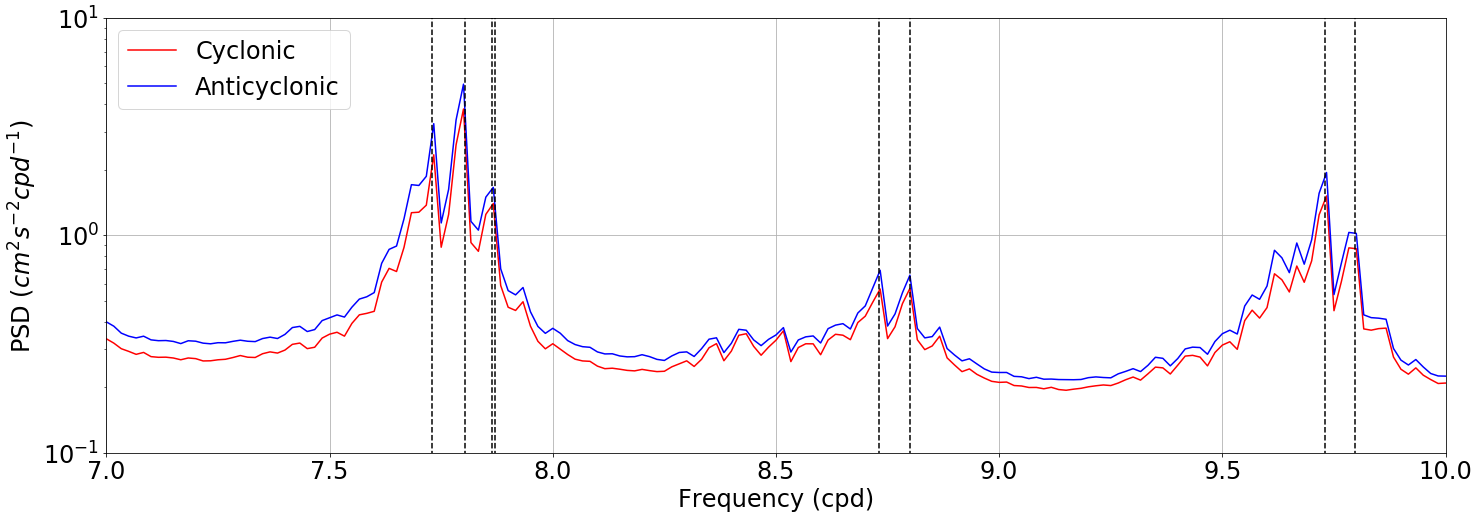

In [81]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(E_cycl_coastal.where(E_cycl_coastal.freq_time>0)).plot(ax=ax,color='red', label=labels[0])
(E_anti_coastal.where(E_anti_coastal.freq_time>0)).plot(ax=ax,color='blue', label=labels[1])

ax.legend(); ax.grid()
ax.set_yscale('log')
#ax.set_ylim([-0.5,4.5])
#ax.set_yticks([-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5])

ax.set_xlim([7.,10.])
ax.set_ylim([1e-1,1e1])


#ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('')


# 8
ax.plot([7.72909,7.72909],[1e-2,1e6],'k--') # M8
ax.plot([7.8023,7.8023],[1e-2,1e6],'k--')   # 3MK8
ax.plot([7.86455,7.86455],[1e-2,1e6],'k--') # ST23


# 9
ax.plot([8.73183,8.73183],[1e-2,1e6],'k--') # M4MK9
ax.plot([8.79956,8.79956],[1e-2,1e6],'k--') # ST27


# 10
ax.plot([9.72909,9.72909],[1e-2,1e6],'k--') # ST30
ax.plot([9.79682,9.79682],[1e-2,1e6],'k--') # ST32

# 11
ax.plot([10.7318,10.7318],[1e-2,1e6],'k--') # ST33


# 12
ax.plot([11.6614,11.6614],[1e-2,1e6],'k--') # ST34

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Globally_averaged_PSD_nowindow_3.png')



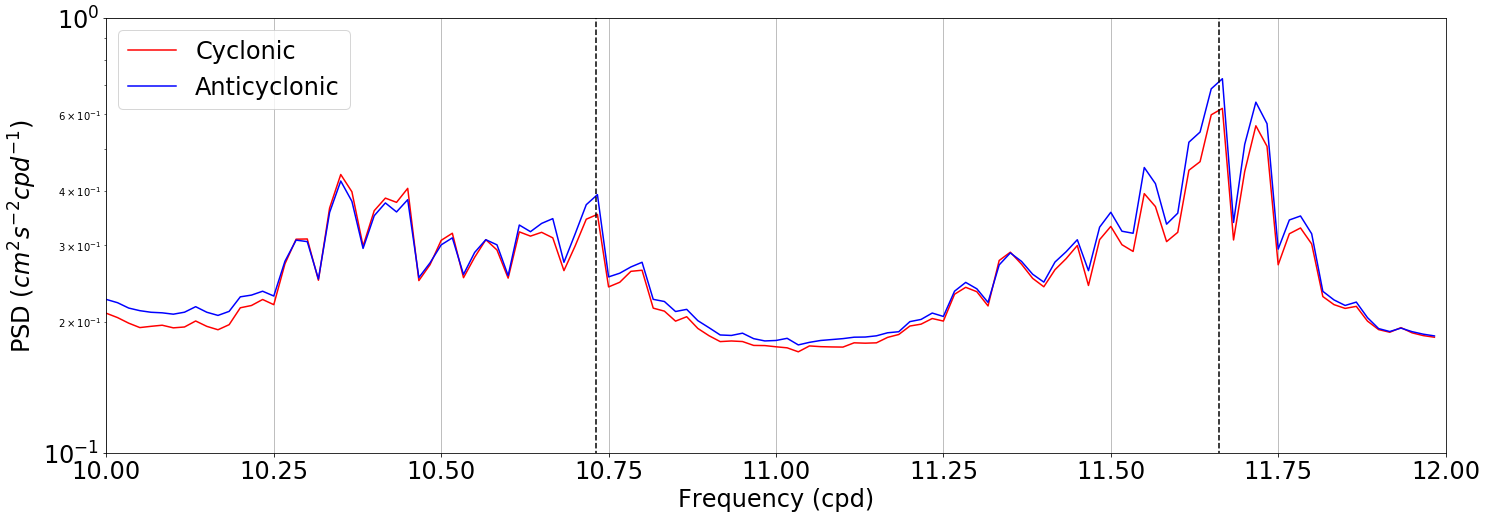

In [75]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']


(E_cycl_coastal.where(E_cycl_coastal.freq_time>0)).plot(ax=ax,color='red', label=labels[0])
(E_anti_coastal.where(E_anti_coastal.freq_time>0)).plot(ax=ax,color='blue', label=labels[1])

ax.legend(); ax.grid()
ax.set_yscale('log')
#ax.set_ylim([-0.5,4.5])
#ax.set_yticks([-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5])

ax.set_xlim([10.,12.])
ax.set_ylim([1e-1,1e0])


#ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('')

# Diurnal frequencies
ax.plot([24/25.81933871,24/25.81933871],[1e-2,1e6],'k--') # O1
ax.plot([1,1],[1e-2,1e6],'k--') # S1

# Semi-diurnal frequencies
ax.plot([1.93227,1.93227],[1e-2,1e6],'k--') # M2
ax.plot([2,2],[1e-2,1e6],'k--') # S2

# 3
ax.plot([2.86181,2.86181],[1e-2,1e6],'k--') # MO3
ax.plot([2.93501,2.93501],[1e-2,1e6],'k--') # MK3
ax.plot([3.00274,3.00274],[1e-2,1e6],'k--') # SK3

# 4
ax.plot([3.86455,3.86455],[1e-2,1e6],'k--') # M4
ax.plot([3.93227,3.93227],[1e-2,1e6],'k--') # MS4
ax.plot([4,4],[1e-2,1e6],'k--') # S4

# 5
ax.plot([4.79956,4.79956],[1e-2,1e6],'k--') # 3MP5
ax.plot([4.86729,4.86729],[1e-2,1e6],'k--') # 2MK5
ax.plot([4.93501,4.93501],[1e-2,1e6],'k--') # MSK5

# 6
ax.plot([5.79682,5.79682],[1e-2,1e6],'k--') # M6
ax.plot([5.86455,5.86455],[1e-2,1e6],'k--') # 2MS6
ax.plot([5.93227,5.93227],[1e-2,1e6],'k--') # 2SM6

# 7
ax.plot([6.79956,6.79956],[1e-2,1e6],'k--') # 3MK7
ax.plot([6.86729,6.86729],[1e-2,1e6],'k--') # ST17

# 8
ax.plot([7.72909,7.72909],[1e-2,1e6],'k--') # M8
ax.plot([7.8023,7.8023],[1e-2,1e6],'k--')   # 3MK8
ax.plot([7.86455,7.86455],[1e-2,1e6],'k--') # ST23

# 9
ax.plot([8.73183,8.73183],[1e-2,1e6],'k--') # M4MK9
ax.plot([8.79956,8.79956],[1e-2,1e6],'k--') # ST27


# 10
ax.plot([9.72909,9.72909],[1e-2,1e6],'k--') # ST30
ax.plot([9.79682,9.79682],[1e-2,1e6],'k--') # ST32

# 11
ax.plot([10.7318,10.7318],[1e-2,1e6],'k--') # ST33


# 12
ax.plot([11.6614,11.6614],[1e-2,1e6],'k--') # ST34

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Globally_averaged_PSD_nowindow_4.png')



# 4. Spatial variablity of some specific frequencies (e.g. M2,K1)

## 4.1 Geographic variablity along US

In [9]:
face = 10

file_E = E_dir+'E_uv_f%02d.nc'%face    
ds = xr.open_dataset(file_E, chunks={'i': 10, 'j': 432})
ds = ds.assign_coords(freq_cpd=ds.freq_time * 86400.)
print(ds)

<xarray.Dataset>
Dimensions:            (freq_time: 1440, i: 4320, j: 4320)
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 ...
    face               int64 ...
    XC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    YC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    rA                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    Depth              (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
Data variables:
    E_uv               (i, j, freq_time) float64 dask.array<shape=(4320, 4320, 1440), chunksize=(10, 432, 1440)>


In [10]:
E = ds['E_uv']
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)

<xarray.DataArray 'E_uv' (i: 4320, j: 4320, freq_time: 1440)>
dask.array<shape=(4320, 4320, 1440), dtype=float64, chunksize=(10, 432, 1440)>
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 ...
    face               int64 ...
    XC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    YC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    rA                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    Depth              (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...


In [11]:
df=E.freq_time[1]-E.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(1.929012e-07)
Coordinates:
    freq_time_spacing  float64 1.929e-07
    face               int64 10


In [ ]:
E_all = (E*df).sum(dim='freq_time')
E_all = np.real(E_all).rename('E_all')

#E = xr.merge([E_all, E_sdiurnal, E_diurnal])
file_E = E_dir+'E_bands_f%02d.nc'%face
E_all.to_netcdf(file_E, mode='w')  


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [ ]:

E_sdiurnal = (E.where((abs(E.freq_cpd)>1.9) & (abs(E.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time')
E_sdiurnal = np.real(E_sdiurnal).rename('E_sdiurnal')

file_E = E_dir+'E_sdiurnal_f%02d.nc'%face
E_sdiurnal.to_netcdf(file_E, mode='w')


E_diurnal = (E.where((abs(E.freq_cpd)>0.9) & (abs(E.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time')
E_diurnal = np.real(E_diurnal).rename('E_diurnal')

#E = xr.merge([E_all, E_sdiurnal, E_diurnal])
file_E = E_dir+'E_diurnal_f%02d.nc'%face
E_diurnal.to_netcdf(file_E, mode='w')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [ ]:
E_low = (E.where((abs(E.freq_cpd)>0) & (abs(E.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time')
E_low = np.real(E_low).rename('E_low')
file_E = E_dir+'E_low_f%02d.nc'%face
E_low.to_netcdf(file_E, mode='w')


f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.YC))
f_cpd = f*86400/2./np.pi
E_f = (E.where(abs(E.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq_time')
E_f = np.real(E_f).rename('E_f')
file_E = E_dir+'E_f_f%02d.nc'%face
E_f.to_netcdf(file_E, mode='w')



/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:820: UserWarning: Large object of size 2.12 MB detected in task graph: 
  ("('open_dataset-17d302646419a888580d88ac151ddb7dX ... d470>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


In [12]:
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.YC))
f_cpd = f*86400/2./np.pi

In [ ]:
E_f = (E.where(abs(E.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq_time')
E_f = np.real(E_f).rename('E_f')
file_E = E_dir+'E_f_f%02d.nc'%face
E_f.to_netcdf(file_E, mode='w')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:820: UserWarning: Large object of size 5.08 MB detected in task graph: 
  ("('transpose-80cb726f6a5c12f7345edab8dc966b1a', 0 ... 1c60>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


### China

In [12]:
face = 5

file_E = E_dir+'E_uv_f%02d.nc'%face    
ds = xr.open_dataset(file_E, chunks={'i': 10, 'j': 432})
E = ds['E_uv']
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)

df=E.freq_time[1]-E.freq_time[0]

<xarray.DataArray 'E_uv' (i: 4320, j: 4320, freq_time: 1440)>
dask.array<shape=(4320, 4320, 1440), dtype=float64, chunksize=(10, 432, 1440)>
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 ...
    face               int64 ...
    XC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    YC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    rA                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    Depth              (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...


In [7]:
E_all = (E*df).sum(dim='freq_time')
E_all = np.real(E_all).rename('E_all')

file_E = E_dir+'E_bands_f%02d.nc'%face
E_all.to_netcdf(file_E, mode='w')  


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:820: UserWarning: Large object of size 1.90 MB detected in task graph: 
  ("('open_dataset-41dfac0d8997135cb3939548ab79ac71X ... 665d>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


In [ ]:

E_sdiurnal = (E.where((abs(E.freq_cpd)>1.9) & (abs(E.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time')
E_sdiurnal = np.real(E_sdiurnal).rename('E_sdiurnal')

file_E = E_dir+'E_sdiurnal_f%02d.nc'%face
E_sdiurnal.to_netcdf(file_E, mode='w')


E_diurnal = (E.where((abs(E.freq_cpd)>0.9) & (abs(E.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time')
E_diurnal = np.real(E_diurnal).rename('E_diurnal')

#E = xr.merge([E_all, E_sdiurnal, E_diurnal])
file_E = E_dir+'E_diurnal_f%02d.nc'%face
E_diurnal.to_netcdf(file_E, mode='w')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [ ]:
E_low = (E.where((abs(E.freq_cpd)>0) & (abs(E.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time')
E_low = np.real(E_low).rename('E_low')
file_E = E_dir+'E_low_f%02d.nc'%face
E_low.to_netcdf(file_E, mode='w')


f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.YC))
f_cpd = f*86400/2./np.pi
E_f = (E.where(abs(E.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq_time')
E_f = np.real(E_f).rename('E_f')
file_E = E_dir+'E_f_f%02d.nc'%face
E_f.to_netcdf(file_E, mode='w')



In [8]:
E_all = (E.isel(i=slice(2500,4320), j=slice(0,2000))*df).sum(dim='freq_time')
E_all = np.real(E_all).rename('E_all')

E_sdiurnal = (E.isel(i=slice(2500,4320), j=slice(0,2000)).where((abs(E.freq_cpd)>1.9) & (abs(E.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time')
E_sdiurnal = np.real(E_sdiurnal).rename('E_sdiurnal')

E_diurnal = (E.isel(i=slice(2500,4320), j=slice(0,2000)).where((abs(E.freq_cpd)>0.9) & (abs(E.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time')
E_diurnal = np.real(E_diurnal).rename('E_diurnal')

E_low = (E.isel(i=slice(2500,4320), j=slice(0,2000)).where((abs(E.freq_cpd)>0) & (abs(E.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time')
E_low = np.real(E_low).rename('E_low')

#f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.YC))
#f_cpd = f*86400/2./np.pi
#E_f = (E.isel(i=slice(2500,4320), j=slice(0,2000)).where(abs(E.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq_time')
#E_f = np.real(E_f).rename('E_f')

E_bands = xr.merge([E_all, E_sdiurnal, E_diurnal, E_low])
file_E = E_dir+'E_bands_f%02d.nc'%face
E_bands.to_netcdf(file_E, mode='w')  


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:820: UserWarning: Large object of size 3.39 MB detected in task graph: 
  ("('where-bba4a31e6ccf08cf35ac5c79db12b403', 0, 0) ... 8160>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


### 4.2 Figures

In [6]:
face = 10

filenames_1 = sorted(glob(E_dir+'E_bands_f10.nc'))
filenames_2 = sorted(glob(E_dir+'E_sdiurnal_f10.nc'))
filenames_3 = sorted(glob(E_dir+'E_diurnal_f10.nc'))
filenames_4 = sorted(glob(E_dir+'E_low_f10.nc'))

# Grid #
grid = mgrid.isel(face=face)
# Read SSU #
ds_1 = xr.open_mfdataset(filenames_1)
ds_2 = xr.open_mfdataset(filenames_2)
ds_3 = xr.open_mfdataset(filenames_3)
ds_4 = xr.open_mfdataset(filenames_4)

ds = xr.merge([ds_1,ds_2,ds_3,ds_4])
print(ds)

<xarray.Dataset>
Dimensions:            (i: 4320, j: 4320)
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    freq_time_spacing  float64 1.929e-07
    face               int64 10
    XC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    YC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    rA                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    Depth              (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
Data variables:
    E_all              (i, j) float64 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    E_sdiurnal         (i, j) float64 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    E_diurnal          (i, j) float64 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    E_low              (i,

In [10]:
face = 5

filenames_1 = sorted(glob(E_dir+'E_bands_f05.nc'))

# Grid #
grid = mgrid.isel(face=face)
# Read SSU #
ds_1 = xr.open_mfdataset(filenames_1)

#ds = xr.merge([ds_1,ds_2,ds_3,ds_4])
#print(ds)

### Total KE

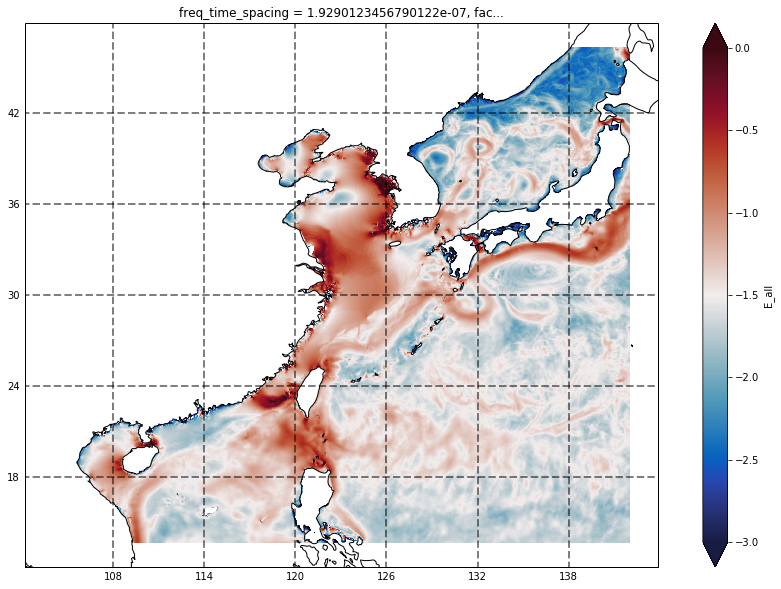

In [11]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  np.log10(ds_1['E_all'].isel(i=slice(2500,4320), j=slice(0,2000))).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = -3, vmax = 0.,cmap = cm.balance) #, vmin = -2, vmax = 0.5

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

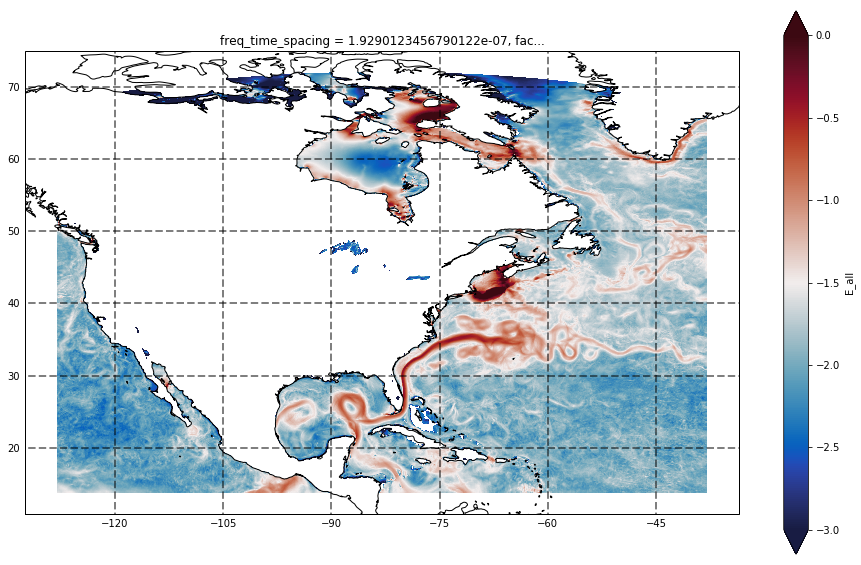

In [8]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  np.log10(ds['E_all']).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = -3, vmax = 0.,cmap = cm.balance) #, vmin = -2, vmax = 0.5

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

In [139]:
E_all_mean = ds['E_all'].mean(dim=['i','j']).compute()
print(E_all_mean)

### low-frequency(<2cpd)/total KE

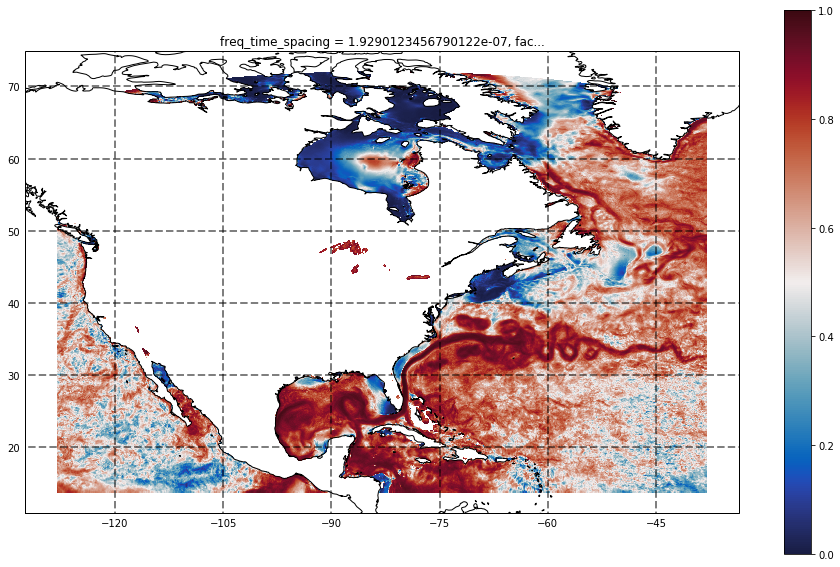

In [7]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  (ds['E_low']/ds['E_all']).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = 0, vmax = 1,cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

### Semi-diurnal/total KE

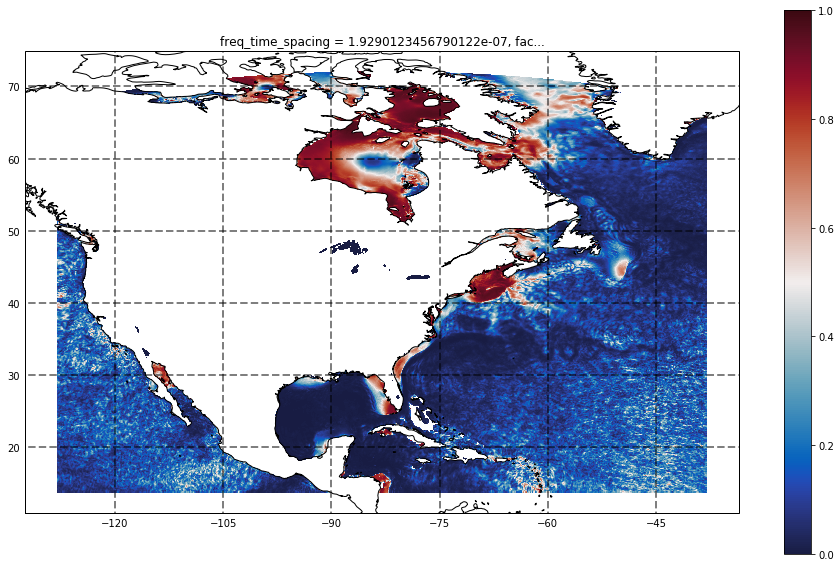

In [10]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  (ds['E_sdiurnal']/ds['E_all']).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = 0, vmax = 1,cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

### Diurnal/total KE

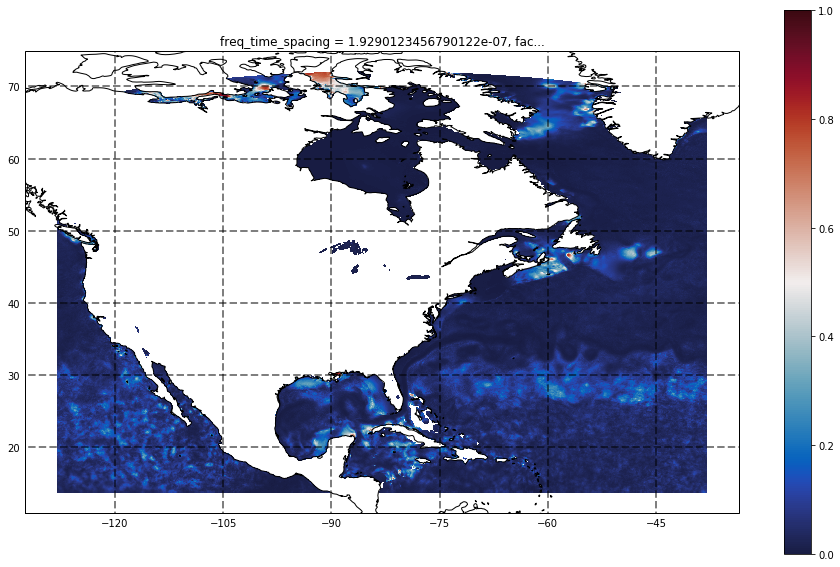

In [8]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  (ds['E_diurnal']/ds['E_all']).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = 0, vmax = 1,cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

### Near-inertial/total KE

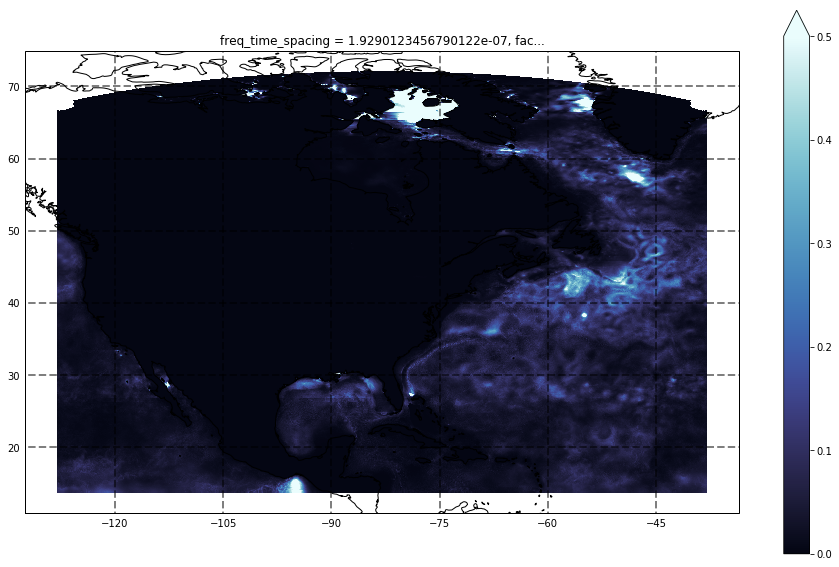

In [145]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  (ds['E_f']/ds['E_all']).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = 0, vmax = 1,cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

## 4.2 PSD at face 5

In [ ]:
face = 5

file_E = E_dir+'E_uv_f%02d.nc'%face    
ds = xr.open_dataset(file_E, chunks={'i': 10, 'j': 432})
ds = ds.assign_coords(freq_cpd=ds.freq_time * 86400.)
print(ds)

In [41]:
print(ds.freq_cpd[120]) # 1 cpd

<xarray.DataArray 'freq_cpd' ()>
array(2.)
Coordinates:
    freq_time          float64 2.315e-05
    freq_time_spacing  float64 ...
    face               int64 ...
    freq_cpd           float64 2.0


In [42]:
eta = ds['E_uv'].isel(freq_time=120, i=slice(2500,4320), j=slice(0,2000)).persist() # 2 cpd

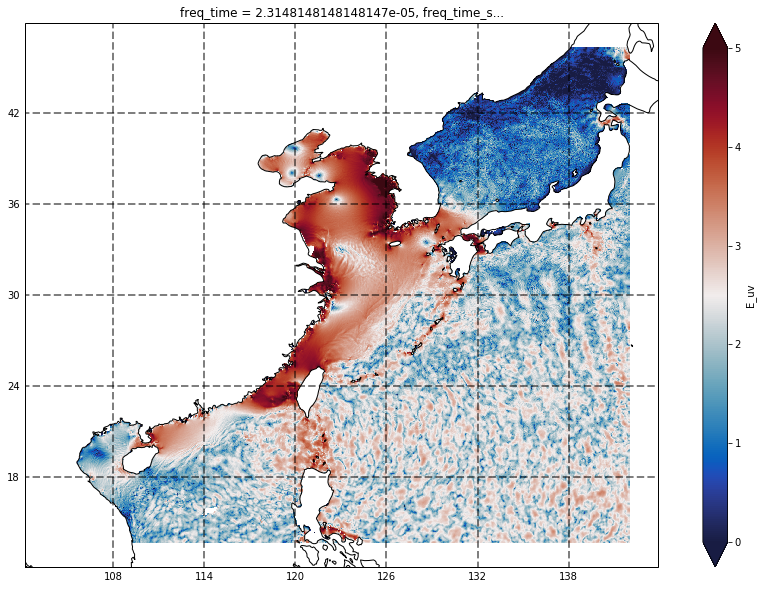

In [43]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  np.log10(eta).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = 0, vmax = 5, cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

In [44]:
eta = ds['E_uv'].isel(freq_time=60, i=slice(2500,4320), j=slice(0,2000)).persist() # 1 cpd

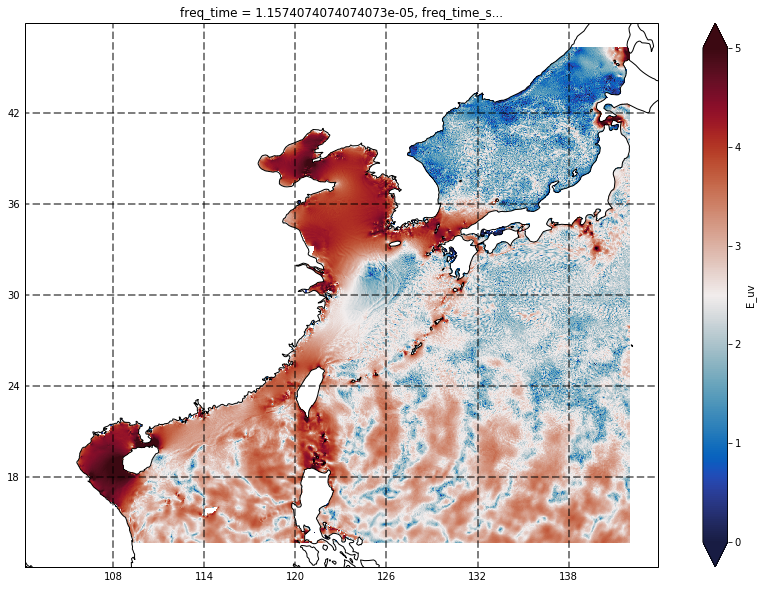

In [45]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  np.log10(eta).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = 0, vmax = 5, cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

# 5. Spatial-averaged spectra

In [5]:
E_dir = '/home1/scratch/xyu/mit_spec/zavg_UV_window/'

In [6]:
face = 1

file_E = E_dir+'E_uv_f%02d.nc'%face    
ds = xr.open_dataset(file_E, chunks={'i': 10, 'j': 432})
ds = ds.assign_coords(freq_cpd=ds.freq_time * 86400.)
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:            (freq_time: 1440, i: 4320, j: 4320)
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 ...
    face               int64 ...
    XC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    YC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    rA                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    Depth              (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
Data variables:
    E_uv               (i, j, freq_time) float64 dask.array<shape=(4320, 4320, 1440), chunksize=(10, 432, 1440)>

 data size: 215.3 GB


In [7]:
%time E = ds['E_uv'].mean(dim=('i','j')).load()

CPU times: user 1min 21s, sys: 3.46 s, total: 1min 25s
Wall time: 9min 35s


In [8]:
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)

<xarray.DataArray 'E_uv' (freq_time: 1440)>
array([1.064459e-08, 2.279952e+04, 1.702352e+04, ..., 9.479996e+03,
       1.745471e+04, 2.369208e+04])
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 1.929e-07
    face               int64 1
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...


### cm^2 s^-2/cpd

In [9]:
E0 = E/8.64

No handles with labels found to put in legend.


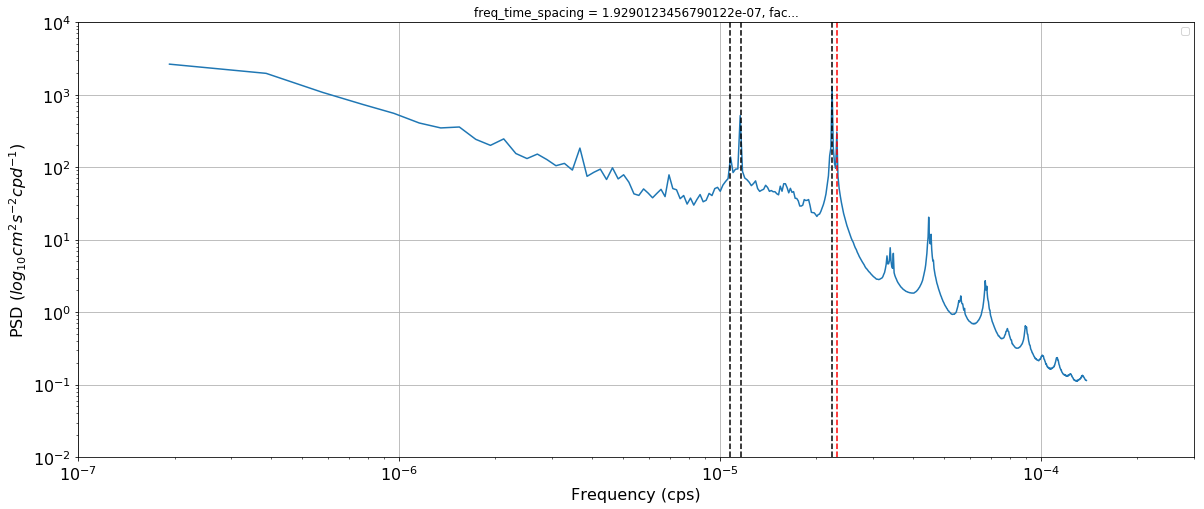

In [14]:
# SSU spectral plot


fig, ax = plt.subplots(figsize=(20,8))

E0.where(E0.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')

#ax.set_ylabel(''); 
ax.set_ylim([1e-2,1e4])
ax.set_xlim([1e-7,3*1e-4])

# Semi-diurnal frequencies#
ax.plot([1/12.42/3600,1/12.42/3600],[1e-2,1e6],'k--') # M2
ax.plot([1/12/3600,1/12/3600],[1e-2,1e6],'r--')  # S2

# Diurnal frequencies#

ax.plot([1/23.93/3600,1/23.93/3600],[1e-2,1e6],'k--')      # K1
ax.plot([1/25.81/3600,1/25.81/3600],[1e-2,1e6],'k--') # O1


#ax.set_xlim(-5., 5.)
#ax.set_ylim(-60., 60.)
#ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])

ax.set_ylabel('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$',fontsize=16)
ax.set_xlabel('Frequency (cps)',fontsize=16)
ax.tick_params(labelsize=16)

No handles with labels found to put in legend.


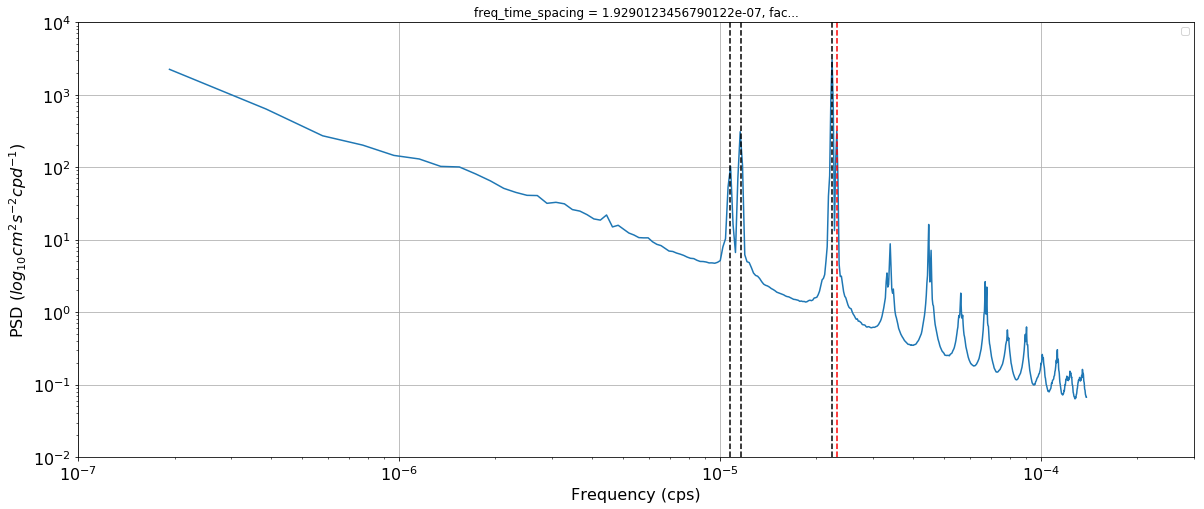

In [66]:
# SSU spectral plot


fig, ax = plt.subplots(figsize=(20,8))

E0.where(E0.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')

#ax.set_ylabel(''); 
ax.set_ylim([1e-2,1e4])
ax.set_xlim([1e-7,3*1e-4])

# Semi-diurnal frequencies#
ax.plot([1/12.42/3600,1/12.42/3600],[1e-2,1e6],'k--') # M2
ax.plot([1/12/3600,1/12/3600],[1e-2,1e6],'r--')  # S2

# Diurnal frequencies#

ax.plot([1/23.93/3600,1/23.93/3600],[1e-2,1e6],'k--')      # K1
ax.plot([1/25.81/3600,1/25.81/3600],[1e-2,1e6],'k--') # O1


#ax.set_xlim(-5., 5.)
#ax.set_ylim(-60., 60.)
#ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])

ax.set_ylabel('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$',fontsize=16)
ax.set_xlabel('Frequency (cps)',fontsize=16)
ax.tick_params(labelsize=16)

No handles with labels found to put in legend.


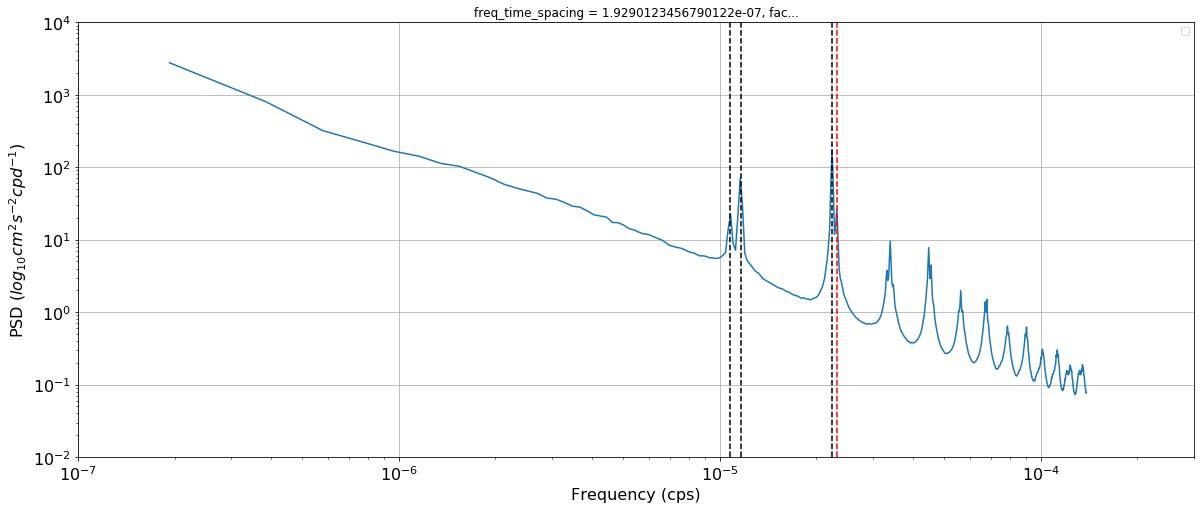

In [46]:
# SSU spectral plot


fig, ax = plt.subplots(figsize=(20,8))

E0.where(E0.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')

#ax.set_ylabel(''); 
ax.set_ylim([1e-2,1e4])
ax.set_xlim([1e-7,3*1e-4])

# Semi-diurnal frequencies#
ax.plot([1/12.42/3600,1/12.42/3600],[1e-2,1e6],'k--') # M2
ax.plot([1/12/3600,1/12/3600],[1e-2,1e6],'r--')  # S2

# Diurnal frequencies#

ax.plot([1/23.93/3600,1/23.93/3600],[1e-2,1e6],'k--')      # K1
ax.plot([1/25.81/3600,1/25.81/3600],[1e-2,1e6],'k--') # O1


#ax.set_xlim(-5., 5.)
#ax.set_ylim(-60., 60.)
#ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])

ax.set_ylabel('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$',fontsize=16)
ax.set_xlabel('Frequency (cps)',fontsize=16)
ax.tick_params(labelsize=16)

### m^2 s^-2/cpd

In [67]:
E1 = E/86400

No handles with labels found to put in legend.


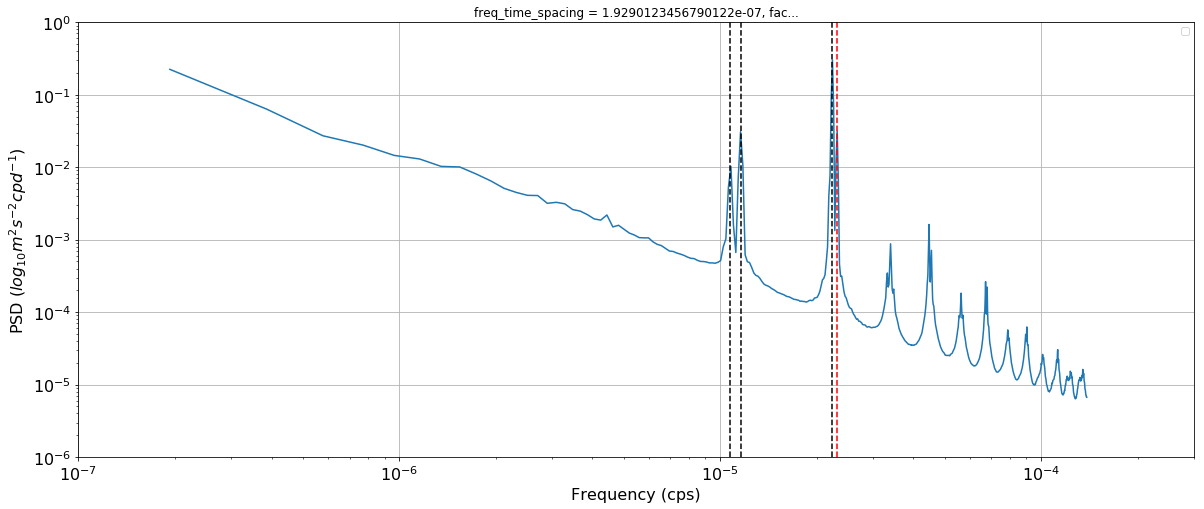

In [72]:
# SSU spectral plot


fig, ax = plt.subplots(figsize=(20,8))

E1.where(E1.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')

#ax.set_ylabel(''); 
ax.set_ylim([1e-6,1e0])
ax.set_xlim([1e-7,3*1e-4])

# Semi-diurnal frequencies#
ax.plot([1/12.42/3600,1/12.42/3600],[1e-6,1e6],'k--') # M2
ax.plot([1/12/3600,1/12/3600],[1e-6,1e6],'r--')  # S2

# Diurnal frequencies#

ax.plot([1/23.93/3600,1/23.93/3600],[1e-6,1e6],'k--')      # K1
ax.plot([1/25.81/3600,1/25.81/3600],[1e-6,1e6],'k--') # O1


#ax.set_xlim(-5., 5.)
#ax.set_ylim(-60., 60.)
#ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])

ax.set_ylabel('PSD ($log_{10} m^2 s^{-2} cpd^{-1})$',fontsize=16)
ax.set_xlabel('Frequency (cps)',fontsize=16)
ax.tick_params(labelsize=16)

### m^2 s^-2/cph

In [74]:
E2 = E/0.36

No handles with labels found to put in legend.


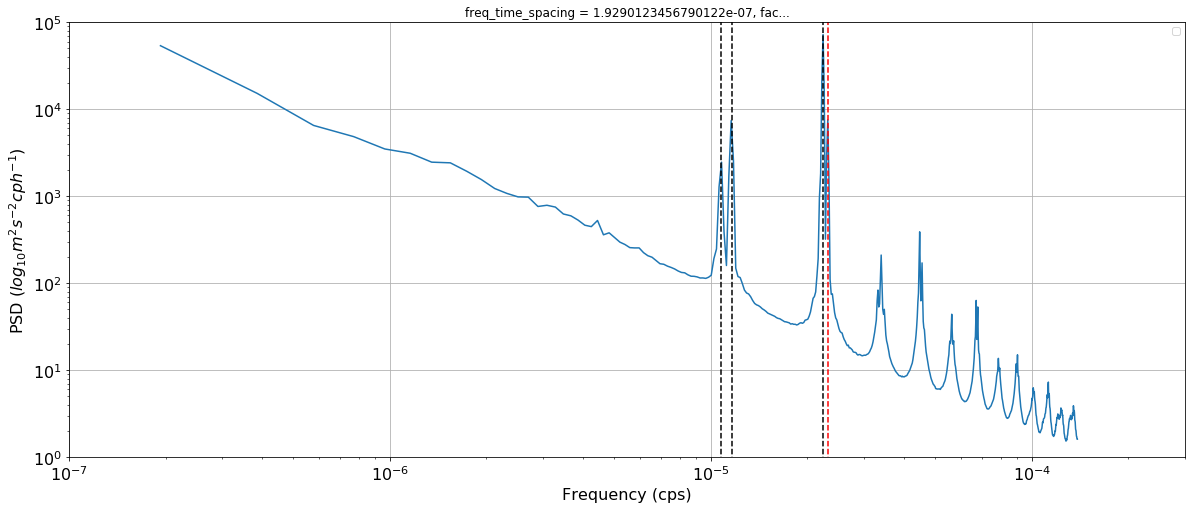

In [84]:
# SSU spectral plot


fig, ax = plt.subplots(figsize=(20,8))

E2.where(E2.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')


#ax.set_ylabel(''); 
ax.set_ylim([1e0,1e5])
ax.set_xlim([1e-7,3*1e-4])

# Semi-diurnal frequencies#
ax.plot([1/12.42/3600,1/12.42/3600],[1e-6,1e6],'k--') # M2
ax.plot([1/12/3600,1/12/3600],[1e-6,1e6],'r--')  # S2

# Diurnal frequencies#

ax.plot([1/23.93/3600,1/23.93/3600],[1e-6,1e6],'k--')      # K1
ax.plot([1/25.81/3600,1/25.81/3600],[1e-6,1e6],'k--') # O1


#ax.set_xlim(-5., 5.)
#ax.set_ylim(-60., 60.)
#ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])

ax.set_ylabel('PSD ($log_{10} m^2 s^{-2} cph^{-1})$',fontsize=16)
ax.set_xlabel('Frequency (cps)',fontsize=16)
ax.tick_params(labelsize=16)

---

In [16]:
cluster.scheduler.close()

<Future finished result=None>

In [87]:
client.restart()

<Client: scheduler='tcp://10.148.1.6:35881' processes=0 cores=0>